Instalación de librerias y dataframe inicial

In [ ]:
!pip install statsbombpy
from statsbombpy import sb
!pip install mplsoccer
import pandas as pd
from mplsoccer import VerticalPitch,Pitch
import numpy as np

In [ ]:
events_df = sb.competition_events(
country="Germany",
division="1. Bundesliga",
season="2023/2024",
gender="male")

events_df.shape

(137765, 111)

In [ ]:
frames_df = sb.competition_frames(
country="Germany",
division="1. Bundesliga",
season="2023/2024",
gender="male")

frames_df.shape

(1953182, 7)

In [ ]:
bundesliga_2324 = sb.matches(competition_id = 9, season_id = 281)
bundesliga_2324.shape

(34, 22)

In [ ]:
# Renombrar columna en frames_df para que coincida con events_df
frames_df.rename(columns={'event_uuid': 'id'}, inplace=True)

# Fusionar events_df con frames_df (manteniendo todos los eventos)
merged_df = pd.merge(events_df, frames_df, how="left", on=["match_id", "id"])

# Fusionar con bundesliga_2324 usando match_id
merged_df = pd.merge(merged_df, bundesliga_2324, how="left", on="match_id")

pd.set_option('display.max_columns', None)

Creación del dataset GOALKICKS_DF

In [ ]:
def actualizar_marcador(df):
    # Copia del DataFrame para evitar modificar el original
    df = df.copy()

    # Convertimos la columna 'minute' a tipo numérico
    df['minute'] = pd.to_numeric(df['minute'], errors='coerce')

    # Inicializamos la columna 'irt_result' con el marcador inicial
    df['irt_result'] = '0 - 0'

    # Filtramos solo los eventos de goles (concedidos o penales)
    goles_df = df[df['goalkeeper_type'].isin(['Goal Conceded', 'Penalty Conceded'])][['minute', 'team', 'match_id']].drop_duplicates()

    # Ordenamos los goles por partido y minuto
    goles_df = goles_df.sort_values(by=['match_id', 'minute'])

    # Diccionario para almacenar la evolución del marcador en cada partido
    marcadores = {}

    # Iteramos sobre los goles detectados
    for _, gol in goles_df.iterrows():
        minuto = gol['minute']
        equipo_que_recibe_gol = gol['team']  # Equipo que sufre el gol
        match_id = gol['match_id']

        # Obtener los equipos local y visitante de ese partido
        match_data = df[df['match_id'] == match_id].iloc[0]
        home_team = match_data['home_team']
        away_team = match_data['away_team']

        # Inicializar el marcador del partido si aún no existe
        if match_id not in marcadores:
            marcadores[match_id] = {home_team: 0, away_team: 0}

        # Determinar qué equipo marcó el gol
        equipo_que_marca = home_team if equipo_que_recibe_gol == away_team else away_team

        # Sumar un gol al equipo correcto
        marcadores[match_id][equipo_que_marca] += 1

        # Generar el marcador actualizado en formato "goles_local - goles_visitante"
        marcador_str = f"{marcadores[match_id][home_team]} - {marcadores[match_id][away_team]}"

        # Aplicar el marcador a todas las filas del partido a partir de ese minuto
        df.loc[(df['minute'] >= minuto) & (df['match_id'] == match_id), 'irt_result'] = marcador_str

    return df

# Aplicamos la función al DataFrame
merged_df = actualizar_marcador(merged_df)

merged_df.head()

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_other,clearance_right_foot,counterpress,dribble_no_touch,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_committed_penalty,foul_committed_type,foul_won_advantage,foul_won_defensive,foul_won_penalty,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_punched_out,goalkeeper_shot_saved_off_target,goalkeeper_shot_saved_to_post,goalkeeper_success_in_play,goalkeeper_success_out,goalkeeper_technique,goalkeeper_type,id,index,injury_stoppage_in_chain,interception_outcome,location_x,match_id,minute,miscontrol_aerial_won,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_miscommunication,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_deflected,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_open_goal,shot_outcome,shot_saved_off_target,shot_saved_to_post,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure,actor,keeper,location_y,teammate,visible_area,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version,irt_result
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,794ec549-5288-4d1a-93e8-0fc6d3968784,1,NaN,NaN,NaN,3895302,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Bayer Leverkusen,904,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 3421, 'lineup': [{'player': {'id...",Bayer Leverkusen,904,00:00:00.000,Starting XI,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-14,17:30:00.000,Germany - 1. Bundesliga,2023/2024,Bayer Leverkusen,Werder Bremen,5,0,available,available,2024-05-10T16:57:53.017895,2024-05-10T17:03:59.613154,29,Regular Season,BayArena,Harm Osmers,Xabier Alonso Olano,Ole Werner,1.1.0,2,2,0 - 0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3a9a2c57-b177-47ed-9447-11f081b0e388,2,NaN,NaN,NaN,3895302,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Bayer Leverkusen,904,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 352, 'lineup': [{'player': {'id'...",Werder Bremen,176,00:00:00.000,Starting XI,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-14,17:30:00.000,Germany - 1. Bundesliga,2023/2024,Bayer Leverkusen,Werder Bremen,5,0,available,available,2024-05-10T16:57:53.017895,2024-05-10T17:03:59.613154,29,Regular Season,BayArena,Harm Osmers,Xabier Alonso Olano,Ole Werner,1.1.0,2,2,0 - 0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49e1fcf3

In [ ]:
import unittest
import pandas as pd

class TestActualizarMarcador(unittest.TestCase):

    def setUp(self):
        """Crear un DataFrame de prueba con distintos escenarios."""
        self.df_base = pd.DataFrame([
            {'match_id': '1', 'minute': 5, 'goalkeeper_type': None, 'team': 'Bayer Leverkusen', 'home_team': 'Bayer Leverkusen', 'away_team': 'Werder Bremen'},
            {'match_id': '1', 'minute': 10, 'goalkeeper_type': 'Goal Conceded', 'team': 'Bayer Leverkusen', 'home_team': 'Bayer Leverkusen', 'away_team': 'Werder Bremen'},
            {'match_id': '2', 'minute': 15, 'goalkeeper_type': 'Goal Conceded', 'team': 'Werder Bremen', 'home_team': 'Bayer Leverkusen', 'away_team': 'Werder Bremen'},
            {'match_id': '1', 'minute': 20, 'goalkeeper_type': None, 'team': 'Bayer Leverkusen', 'home_team': 'Bayer Leverkusen', 'away_team': 'Werder Bremen'},
            {'match_id': '2', 'minute': 25, 'goalkeeper_type': 'Goal Conceded', 'team': 'Bayer Leverkusen', 'home_team': 'Bayer Leverkusen', 'away_team': 'Werder Bremen'},
        ])

    def test_sin_goles(self):
        """Caso: Un partido sin goles debe mantener el marcador 0 - 0."""
        df_sin_goles = self.df_base[self.df_base['goalkeeper_type'].isnull()]
        df_resultado = actualizar_marcador(df_sin_goles)
        self.assertTrue((df_resultado['irt_result'] == '0 - 0').all())

    def test_con_goles(self):
        """Caso: Un partido con goles debe actualizar el marcador correctamente."""
        df_resultado = actualizar_marcador(self.df_base)

        # Verificar marcador después del primer gol (debe ser 0 - 1)
        self.assertEqual(df_resultado.loc[df_resultado['minute'] >= 10, 'irt_result'].iloc[0], '0 - 1')

        # Verificar marcador después del segundo gol (debe ser 1 - 1)
        self.assertEqual(df_resultado.loc[df_resultado['minute'] >= 15, 'irt_result'].iloc[0], '1 - 1')

        # Verificar marcador después del tercer gol (debe ser 1 - 2)
        self.assertEqual(df_resultado.loc[df_resultado['minute'] >= 25, 'irt_result'].iloc[0], '1 - 2')

# Ejecutar las pruebas
unittest.main(argv=[''], exit=False)

F.
FAIL: test_con_goles (__main__.TestActualizarMarcador.test_con_goles)
Caso: Un partido con goles debe actualizar el marcador correctamente.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipython-input-2244135914.py", line 30, in test_con_goles
    self.assertEqual(df_resultado.loc[df_resultado['minute'] >= 15, 'irt_result'].iloc[0], '1 - 1')
AssertionError: '1 - 0' != '1 - 1'
- 1 - 0
?     ^
+ 1 - 1
?     ^


----------------------------------------------------------------------
Ran 2 tests in 0.016s

FAILED (failures=1)


In [ ]:
goal_kicks = merged_df[merged_df['pass_type'] == 'Goal Kick']
goal_kicks

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_other,clearance_right_foot,counterpress,dribble_no_touch,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_committed_penalty,foul_committed_type,foul_won_advantage,foul_won_defensive,foul_won_penalty,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_punched_out,goalkeeper_shot_saved_off_target,goalkeeper_shot_saved_to_post,goalkeeper_success_in_play,goalkeeper_success_out,goalkeeper_technique,goalkeeper_type,id,index,injury_stoppage_in_chain,interception_outcome,location_x,match_id,minute,miscontrol_aerial_won,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_miscommunication,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_deflected,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_open_goal,shot_outcome,shot_saved_off_target,shot_saved_to_post,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure,actor,keeper,location_y,teammate,visible_area,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version,irt_result
589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.285833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6368bac9-cfc5-43d9-b938-17c5beb68b58,104,NaN,NaN,"[3.7, 30.7]",3895302,1,NaN,NaN,NaN,NaN,1.613627,NaN,Left Foot,NaN,NaN,NaN,"[3.4, 37.7]",NaN,Ground Pass,NaN,7.006426,NaN,NaN,NaN,NaN,Michael Zetterer,23198.0,NaN,NaN,NaN,NaN,NaN,Goal Kick,1,From Goal Kick,Milos Veljkovic,6321.0,Left Center Back,6,Werder Bremen,176,[61f3fc46-6018-4a24-aaf3-96c0f841f290],49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Werder Bremen,176,00:01:49.231,Pass,NaN,False,True,"[1.130312571732162, 37.59952129041627]",True,"[0.0, 80.0, 0.0, 26.040609053517358, 16.499761...",2024-04-14,17:30:00.000,Germany - 1. Bundesliga,2023/2024,Bayer Leverkusen,Werder Bremen,5,0,available,available,2024-05-10T16:57:53.017895,2024-05-10T17:03:59.613154,29,Regular Season,BayArena,Harm Osmers,Xabier Alonso Olano,Ole Werner,1.1.0,2,2,0 - 0
590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.285833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6368bac9-cfc5-43d9-b938-17c5beb68b58,104,NaN,NaN,"[3.7, 30.7]",3895302,1,NaN,NaN,NaN,NaN,1.613627,NaN,Left Foot,NaN,NaN,NaN,"[3.4, 37.7]",NaN,Ground Pass,NaN,7.006426,NaN,NaN,NaN,NaN,Michael Zetterer,23198.0,NaN,NaN,NaN,NaN,NaN,Goal Kick,1,From Goal Kick,Milos Veljkovic,6321.0,Left Center Back,6,Werder Bremen,176,[61f3fc46-6018-4a24-aaf3-96c0f841f290],49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Werder Bremen,176,00:01:49.231,Pass,NaN,False,False,"[2.7211663408199627, 51.91206277320726]",True,"[0.0, 80.0, 0.0, 26.040609053517358, 16.499761...",2024-04-14,17:30:00.000,Germany - 1. Bundesliga,2023/2024,Bayer Leverkusen,Werder Brem

In [ ]:
# Filtrar solo eventos del Bayer Leverkusen
leverkusen_events = goal_kicks[goal_kicks['possession_team'] == 'Bayer Leverkusen']

# Extraer todos los jugadores que aparecen como pasadores o receptores
players = pd.concat([
    leverkusen_events['player'],          # jugador que ejecuta el saque
    leverkusen_events['pass_recipient']   # jugador que lo recibe
])

# Eliminar duplicados y valores nulos
unique_players = players.dropna().unique()

# Ordenar alfabéticamente
unique_players_sorted = sorted(unique_players)

# Guardar en una variable
leverkusen_players = unique_players_sorted

# Imprimirlos
print("Jugadores del Bayer 04 Leverkusen que aparecen en los datos:\n")
for player in leverkusen_players:
    print(player)

Jugadores del Bayer 04 Leverkusen que aparecen en los datos:

Adam Hložek
Alejandro Grimaldo García
Amine Adli
Arthur Augusto de Matos Soares
Borja Iglesias Quintas
Edmond Fayçal Tapsoba
Exequiel Alejandro Palacios
Florian Wirtz
Granit Xhaka
Jeremie Frimpong
Jonas Hofmann
Jonathan Tah
Josip Stanišić
Lukáš Hrádecký
Nathan Tella
Odilon Kossonou
Patrik Schick
Piero Martín Hincapié Reyna
Robert Andrich
Victor Okoh Boniface


In [ ]:
# Diccionario de jugadores y sus posiciones
player_positions = {
    'Adam Hložek': 'Right Wing',
    'Alejandro Grimaldo García': 'Left Back',
    'Amine Adli': 'Left Midfield',
    'Arthur Augusto de Matos Soares': 'Right Wing',
    'Borja Iglesias Quintas': 'Center Forward',
    'Edmond Fayçal Tapsoba': 'Right Center Back',
    'Exequiel Alejandro Palacios': 'Right Center Midfield',
    'Florian Wirtz': 'Center Attacking Midfield',
    'Granit Xhaka': 'Center Defensive Midfield',
    'Jeremie Frimpong': 'Right Wing',
    'Jonas Hofmann': 'Right Attacking Midfield',
    'Jonathan Tah': 'Center Back',
    'Josip Stanišić': 'Right Back',
    'Lukáš Hrádecký': 'Goalkeeper',
    'Nathan Tella': 'Right Wing',
    'Odilon Kossonou': 'Right Center Back',
    'Patrik Schick': 'Center Forward',
    'Piero Martín Hincapié Reyna': 'Left Center Back',
    'Robert Andrich': 'Center Defensive Midfield',
    'Victor Okoh Boniface': 'Center Forward'
}

# Crear la columna pass_recipient_position en base al pass_recipient
merged_df['pass_recipient_position'] = merged_df['pass_recipient'].map(player_positions)

Funcionalidad PASSING RATIO:

In [ ]:
import pandas as pd
import numpy as np

def flatten_visible_area(df, id_col='id',
                         actor_flag_col='actor',
                         x_col='location_x', y_col='location_y',
                         teammate_flag_col='teammate'):
    def is_missing(val):
        """True si val (incluso array) contiene al menos un NaN."""
        miss = pd.isna(val)
        if isinstance(miss, np.ndarray):
            return miss.any()
        return bool(miss)

    records = []

    for event_id, group in df.groupby(id_col, sort=False):
        # 1) Base: fila del actor si existe, si no la única
        actor_rows = group[group[actor_flag_col] == True]
        if not actor_rows.empty:
            base = actor_rows.iloc[0].to_dict()
        else:
            base = group.iloc[0].to_dict()

        # 2) Contadores
        t_cnt = 1
        r_cnt = 1

        # 3) Sólo las filas donde actor == False
        visible_rows = group[group[actor_flag_col] == False]
        for _, row in visible_rows.iterrows():
            x_val = row[x_col]
            y_val = row[y_col]
            if is_missing(x_val) or is_missing(y_val):
                continue
            loc = (x_val, y_val)
            if row.get(teammate_flag_col, False):
                base[f'teammate_{t_cnt}'] = loc
                t_cnt += 1
            else:
                base[f'rival_{r_cnt}'] = loc
                r_cnt += 1

        records.append(base)

    # 4) DataFrame aplanado
    flat_df = pd.DataFrame(records)

    # 5) Añadir columnas que falten
    for col in df.columns:
        if col not in flat_df.columns:
            flat_df[col] = None

    # 6) Ordenar si lo quieres
    sort_cols = [id_col, 'match_id', 'period', 'timestamp']
    existing = [c for c in sort_cols if c in flat_df.columns]
    if existing:
        flat_df = flat_df.sort_values(by=existing).reset_index(drop=True)

    return flat_df

# Vuelve a generar tu merged_clean:
merged_clean = flatten_visible_area(merged_df)

merged_clean

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_other,clearance_right_foot,counterpress,dribble_no_touch,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_committed_penalty,foul_committed_type,foul_won_advantage,foul_won_defensive,foul_won_penalty,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_punched_out,goalkeeper_shot_saved_off_target,goalkeeper_shot_saved_to_post,goalkeeper_success_in_play,goalkeeper_success_out,goalkeeper_technique,goalkeeper_type,id,index,injury_stoppage_in_chain,interception_outcome,location_x,match_id,minute,miscontrol_aerial_won,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_miscommunication,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_deflected,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_open_goal,shot_outcome,shot_saved_off_target,shot_saved_to_post,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure,actor,keeper,location_y,teammate,visible_area,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version,irt_result,pass_recipient_position,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,rival_1,rival_2,teammate_7,rival_3,teammate_8,teammate_9,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,teammate_10
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.886701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00009ae2-464f-4189-83e1-d4e09792df6b,3632,NaN,NaN,"[41.1, 33.7]",3895153,73,NaN,NaN,NaN,NaN,-1.062523,NaN,Left Foot,NaN,NaN,NaN,"[57.2, 4.8]",NaN,Ground Pass,NaN,33.082020,NaN,NaN,NaN,NaN,Alejandro Grimaldo García,10336.0,NaN,NaN,NaN,NaN,NaN,NaN,2,From Free Kick,Piero Martín Hincapié Reyna,38004.0,Left Center Back,122,Bayer Leverkusen,904,[7a4c5377-8360-4b7d-a0d0-4ff88c27ee46],16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bayer Leverkusen,904,00:28:16.776,Pass,NaN,True,False,"[41.099998474121094, 33.70000076293945]",True,"[46.16461575818375, 75.02530566204507, 21.5081...",2023-11-25,16:30:00.000,Germany - 1. Bundesliga,2023/2024,Werder Bremen,Bayer Leverkusen,0,3,available,available,2024-02-23T06:50:14.653597,2024-03-26T09:18:16.484394,12,Regular Season,Wohninvest Weserstadion,Martin Petersen,Ole Werner,Xabier Alonso Olano,1.1.0,2,2,0 - 1,Left Back,"([41.1, 33.7], [38.228208766023585, 47.4472256...","([41.1, 33.7], [46.32798304543421, 62.54713667...","([41.1, 33.7], [55.296720043650055, 61.1327980...","([41.1, 33.7], [56.62640849081651, 42.01310320...","([41.1, 33.7], [62.216477294815604, 62.3571390...","([41.1, 33.7], [66.54352953990954, 11.17372903...","([41.1, 33.7], [45.506474368560106, 34.4487364...","([41.1, 33.7], [48.601689373159964, 69.5167713...","([41.1, 33.7], [70.25221806838849, 35.34810995...","([41.1, 33.7], [52.244532007909896, 48.0778446...","([41.1, 33.7], [74.14810888835203, 54.59453110..

In [ ]:
# 1) Tiempo en segundos
merged_clean['time_s'] = merged_clean['minute']*60 + merged_clean['second']

# 2) Filtrar juego corrido
in_play = (merged_clean
           .loc[merged_clean['play_pattern'] == 'Regular Play']
           .sort_values(['match_id','period','time_s']))

# 3) Diferencias temporales
in_play['delta'] = (in_play
                   .groupby(['match_id','period'])['time_s']
                   .diff()
                   .fillna(0))

# 4) Sumar por partido
effective_time = (in_play
                  .groupby('match_id')['delta']
                  .sum()
                  .rename('effective_seconds')
                  .reset_index())

# 5) Convertir a minutos
effective_time['effective_minutes'] = effective_time['effective_seconds'] / 60

In [ ]:
# Celda 1: métricas de pases por partido y por equipo

import pandas as pd

# 1) Creamos un flag booleano para los pases
merged_clean['is_pass'] = merged_clean['type'] == 'Pass'

# 2) Aseguramos un orden cronológico dentro de cada partido
merged_clean = merged_clean.sort_values(['match_id', 'time_s'])

# 3) Contamos de forma acumulativa los pases en cada partido
merged_clean['pass_cumcount'] = (
    merged_clean
    .groupby('match_id')['is_pass']
    .cumsum()
)

# 4) Pases antes de ese evento, por partido
merged_clean['passes_before_event'] = (
    merged_clean['pass_cumcount']
    - merged_clean['is_pass'].astype(int)
)

# 5) Contador acumulado de pases POR EQUIPO
merged_clean['pass_cumcount_team'] = (
    merged_clean
    .groupby(['match_id', 'team'])['is_pass']
    .cumsum()
)

# 6) Pases antes de ese evento, por equipo
merged_clean['passes_before_event_team'] = (
    merged_clean['pass_cumcount_team']
    - merged_clean['is_pass'].astype(int)
)

# 7) Total de pases POR PARTIDO (global)
totals_match = (
    merged_clean.loc[merged_clean['is_pass']]
    .groupby('match_id')
    .size()
    .rename('total_passes')
)
merged_clean['total_passes'] = (
    merged_clean['match_id']
    .map(totals_match)
    .fillna(0)
    .astype(int)
)

# Ahora en merged_clean tienes:
#  - is_pass
#  - pass_cumcount, passes_before_event, total_passes      # por partido
#  - pass_cumcount_team, passes_before_event_team        # por equipo

In [ ]:
# Celda 2: passing ratios de 100 pases en partido y por equipo

import numpy as np
import pandas as pd

# 1) Construir time_map para el partido (match_id, rank) -> time_s
pass_times_m = merged_clean.loc[merged_clean['is_pass'],
                                ['match_id','pass_cumcount','time_s']]
time_map_m = {
    (int(r.match_id), int(r.pass_cumcount)): r.time_s
    for r in pass_times_m.itertuples(index=False)
}

# 2) Delta de 100 pases en el partido
def calc_d100_match(row):
    pb = int(row['passes_before_event'])
    if pb < 100:
        return np.nan
    start = pb - 100 + 1
    t0 = time_map_m.get((int(row.match_id), start))
    t1 = time_map_m.get((int(row.match_id), pb))
    return (t1 - t0) if (t0 is not None and t1 is not None) else np.nan

merged_clean['delta_100_passes_s_match'] = merged_clean.apply(calc_d100_match, axis=1)

# 3) Normalizar → passing_ratio_match
t_m = merged_clean['delta_100_passes_s_match']
min_m, max_m = t_m.min(skipna=True), t_m.max(skipna=True)
merged_clean['passing_ratio_match'] = (t_m - min_m) / (max_m - min_m)


# 4) Construir time_map para el equipo (match_id, team, rank) -> time_s
pass_times_t = merged_clean.loc[merged_clean['is_pass'],
                                ['match_id','team','pass_cumcount_team','time_s']]
time_map_t = {
    (int(r.match_id), r.team, int(r.pass_cumcount_team)): r.time_s
    for r in pass_times_t.itertuples(index=False)
}

# 5) Delta de 100 pases por equipo
def calc_d100_team(row):
    pb = int(row['passes_before_event_team'])
    if pb < 100:
        return np.nan
    start = pb - 100 + 1
    t0 = time_map_t.get((int(row.match_id), row.team, start))
    t1 = time_map_t.get((int(row.match_id), row.team, pb))
    return (t1 - t0) if (t0 is not None and t1 is not None) else np.nan

merged_clean['delta_100_passes_s_team'] = merged_clean.apply(calc_d100_team, axis=1)

# 6) Normalizar → passing_ratio_team
t_t = merged_clean['delta_100_passes_s_team']
min_t, max_t = t_t.min(skipna=True), t_t.max(skipna=True)
merged_clean['passing_ratio_team'] = (t_t - min_t) / (max_t - min_t)

In [ ]:
# --- Etiquetas para passing_ratio_match ---

# 1) Máscara: sólo donde hay un valor válido
mask_match = merged_clean['passing_ratio_match'].notna()

# 2) Inicializa toda la columna a 0 (Match Starting)
merged_clean['passing_ratio_label_match'] = 0

# 3) Calcula los terciles INVIRTIENDO la asignación:
#    labels=[3,2,1] para que el tercil de ratios pequeños (rápido) quede en 3,
#    y el de ratios grandes (lento) quede en 1.
terciles_match = pd.qcut(
    merged_clean.loc[mask_match, 'passing_ratio_match'],
    q=3,
    labels=[3, 2, 1]
).astype(int)

merged_clean.loc[mask_match, 'passing_ratio_label_match'] = terciles_match


# --- Etiquetas para passing_ratio_team ---

mask_team = merged_clean['passing_ratio_team'].notna()
merged_clean['passing_ratio_label_team'] = 0

terciles_team = pd.qcut(
    merged_clean.loc[mask_team, 'passing_ratio_team'],
    q=3,
    labels=[3, 2, 1]
).astype(int)

merged_clean.loc[mask_team, 'passing_ratio_label_team'] = terciles_team


# --- Mapeo final a texto (opcional) ---

label_map = {
    0: "0. Match Starting",
    1: "1. Lento",
    2: "2. Medio",
    3: "3. Rápido"
}

merged_clean['passing_ratio_label_match'] = merged_clean['passing_ratio_label_match'].map(label_map)
merged_clean['passing_ratio_label_team']  = merged_clean['passing_ratio_label_team'].map(label_map)

In [ ]:
# 1) Preparamos un mapping de todas las columnas que queremos copiar
mappings = merged_clean.set_index('id')[
    [
      'passes_before_event',
      'passing_ratio_label_match',
      'passing_ratio_match',
      'passing_ratio_team',
      'passing_ratio_label_team'
    ]
]

# 2) Asignamos cada columna a merged_df usando map()
for col in mappings.columns:
    merged_df[col] = merged_df['id'].map(mappings[col])

In [ ]:
# prompt: Cada evento del dataset goal_kicks tiene múltiples filas porque incluye información sobre todos los jugadores visibles en la zona del evento, diferentes location_x. Para estructurar mejor los datos, es necesario agrupar las filas que comparten el mismo id (match_id no importa) y reorganizar la información de la siguiente manera:
# Ubicación principal:
# Conservar solo la location_x del jugador que tiene actor = True, ya que es el jugador que realiza la acción principal del evento.
# Que hacer con las otras locations que tenemos, las de actor = false.
# Si teammate = True (jugador del mismo equipo que el actor), almacenar su ubicación en una nueva variable con el nombre:  teammate_1 para la primera,  teammate_2, para kla segunda location y teammate_3, etc.
# Si teammate = False (jugador rival), almacenar su ubicación en una nueva variable con el formato rival_1, rival_2, rival_3, etc.
# Con esta transformación, cada evento quedará representado en una sola fila, incluyendo la ubicación del jugador que realiza la acción y las posiciones de los jugadores cercanos organizadas por equipo. Añademe esta informacion en el dataset original sin tocar las otras columnas plis

# Filtrar los eventos de Goal Kick
goal_kicks = merged_df[merged_df['pass_type'] == 'Goal Kick']

# Inicializar lista para almacenar los datos procesados
gk_processed = []

# Agrupar por ID de evento
for event_id, group in goal_kicks.groupby('id'):
    # Extraer la fila del jugador que realiza la acción (actor = True)
    actor_row = group[group['actor'] == True]

    if not actor_row.empty:
        actor_row = actor_row.iloc[0]  # Tomar la primera fila si hay múltiples actores
        gk_dict = {col: actor_row[col] for col in goal_kicks.columns}  # Copiar las columnas originales
        gk_dict['location_y'] = actor_row['location_y']  # Guardar la ubicación del actor

        # Inicializar contadores para teammates y rivales
        teammate_count = 1
        rival_count = 1

        # Iterar sobre las filas donde actor=False
        for _, row in group[group['actor'] == False].iterrows():
            loc_x = row['location_y']  # Extraer la ubicación

            if isinstance(loc_x, list):  # Asegurar que no haya valores NaN o erróneos
                if row['teammate']:
                    gk_dict[f'teammate_{teammate_count}'] = loc_x
                    teammate_count += 1
                else:
                    gk_dict[f'rival_{rival_count}'] = loc_x
                    rival_count += 1

        # Agregar el diccionario a la lista procesada
        gk_processed.append(gk_dict)
    else:
        print(f"Advertencia: No se encontró actor para id {event_id}")  # Mensaje de advertencia opcional

# Convertir la lista a DataFrame
gk_processed_df = pd.DataFrame(gk_processed)

# Asegurar que todas las columnas originales están presentes en el nuevo DataFrame
for col in goal_kicks.columns:
    if col not in gk_processed_df.columns:
        gk_processed_df[col] = None  # Rellenar con None si falta alguna columna

# Combinar con el dataset original sin duplicados
goal_kicks_1 = pd.concat([goal_kicks, gk_processed_df])
goal_kicks_1 = goal_kicks_1.drop_duplicates(subset=['id'], keep='last')

goal_kicks_1.head()

Advertencia: No se encontró actor para id 005af198-79d9-4011-ae54-6b7db23db730
Advertencia: No se encontró actor para id 00ebf5e9-b2e8-4626-b6a2-adf7ec3ae044
Advertencia: No se encontró actor para id 01443b13-4415-41cb-a776-c76b62dc9806
Advertencia: No se encontró actor para id 0163743c-e99f-4efc-916b-84cd8946aebb
Advertencia: No se encontró actor para id 022fd067-91d1-4f6d-a74b-0ccc293d75e1
Advertencia: No se encontró actor para id 03498380-adec-49b0-93a3-43afdbd15b04
Advertencia: No se encontró actor para id 03965b73-6e44-4f28-aa4b-968053597e12
Advertencia: No se encontró actor para id 03c81eb4-1666-42e7-bc95-d23ac90939e0
Advertencia: No se encontró actor para id 04481bb3-cdce-40e7-bc77-1f90121a7cf7
Advertencia: No se encontró actor para id 0470bc02-5a87-4784-82d2-37c73fee1880
Advertencia: No se encontró actor para id 053bfeca-f3ae-41db-ac86-be2970bae058
Advertencia: No se encontró actor para id 0618ff97-d572-4a61-9c9a-9d94ff781fd3
Advertencia: No se encontró actor para id 06799aff-7

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_other,clearance_right_foot,counterpress,dribble_no_touch,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_committed_penalty,foul_committed_type,foul_won_advantage,foul_won_defensive,foul_won_penalty,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_punched_out,goalkeeper_shot_saved_off_target,goalkeeper_shot_saved_to_post,goalkeeper_success_in_play,goalkeeper_success_out,goalkeeper_technique,goalkeeper_type,id,index,injury_stoppage_in_chain,interception_outcome,location_x,match_id,minute,miscontrol_aerial_won,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_miscommunication,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_deflected,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_open_goal,shot_outcome,shot_saved_off_target,shot_saved_to_post,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure,actor,keeper,location_y,teammate,visible_area,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version,irt_result,pass_recipient_position,passes_before_event,passing_ratio_label_match,passing_ratio_match,passing_ratio_team,passing_ratio_label_team,teammate_1,teammate_2,teammate_3,rival_1,rival_2,rival_3,teammate_4,teammate_5,rival_4,teammate_6,rival_5,teammate_7,teammate_8,rival_6,rival_7,teammate_9,rival_8,rival_9,rival_10,teammate_10,rival_11
5750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.917246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e2cb8487-400c-4940-bffb-8f0675220fbe,1486,NaN,NaN,"[4.3, 32.8]",3895302,32,NaN,NaN,NaN,NaN,1.688888,NaN,Left Foot,NaN,NaN,NaN,"[3.6, 38.7]",NaN,Ground Pass,NaN,5.941381,NaN,NaN,NaN,NaN,Lukáš Hrádecký,8667.0,NaN,NaN,NaN,NaN,NaN,Goal Kick,1,From Goal Kick,Edmond Fayçal Tapsoba,30606.0,Left Center Back,54,Bayer Leverkusen,904,[e8eff6f3-690d-459e-9d15-9b6302335040],49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bayer Leverkusen,904,00:32:49.052,Pass,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-14,17:30:00.000,Germany - 1. Bundesliga,2023/2024,Bayer Leverkusen,Werder Bremen,5,0,available,available,2024-05-10T16:57:53.017895,2024-05-10T17:03:59.613154,29,Regular Season,BayArena,Harm Osmers,Xabier Alonso Olano,Ole Werner,1.1.0,2,2,1 - 0,Goalkeeper,412,1. Lento,0.558549,0.322921,1. Lento,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.517168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c037a13a-e287-471e-b617-8efdf0418974,2561,NaN,NaN,"[7.0, 40.8]",3895302,50,NaN,True,NaN,NaN,-0.239826,NaN,Right Foot,NaN,NaN,NaN,"[57.3, 28.5]",NaN,High Pass,NaN,51.782043,NaN,NaN,Incomplete,NaN,Victor Okoh Boniface,32289.0,NaN,NaN,NaN,NaN,NaN,Goal Kick,2,From Goal Kick,Lukáš H

In [ ]:
import unittest

# Función de prueba (actualizada para la validación de tu transformación)
def transformar_datos_goal_kick(df):
    # Filtrar los eventos de Goal Kick
    goal_kicks = df[df['pass_type'] == 'Goal Kick']

    # Inicializar lista para almacenar los datos procesados
    gk_processed = []

    # Agrupar por ID de evento
    for event_id, group in goal_kicks.groupby('id'):
        # Extraer la fila del jugador que realiza la acción (actor = True)
        actor_row = group[group['actor'] == True]

        if not actor_row.empty:
            actor_row = actor_row.iloc[0]  # Tomar la primera fila si hay múltiples actores
            gk_dict = {col: actor_row[col] for col in goal_kicks.columns}  # Copiar las columnas originales
            gk_dict['location_y'] = actor_row['location_y']  # Guardar la ubicación del actor

            # Inicializar contadores para teammates y rivales
            teammate_count = 1
            rival_count = 1

            # Iterar sobre las filas donde actor=False
            for _, row in group[group['actor'] == False].iterrows():
                loc_x = row['location_x']  # Extraer la ubicación

                if isinstance(loc_x, list):  # Asegurar que no haya valores NaN o erróneos
                    if row['teammate']:
                        gk_dict[f'teammate_{teammate_count}'] = loc_x
                        teammate_count += 1
                    else:
                        gk_dict[f'rival_{rival_count}'] = loc_x
                        rival_count += 1

            # Agregar el diccionario a la lista procesada
            gk_processed.append(gk_dict)
        else:
            print(f"Advertencia: No se encontró actor para id {event_id}")  # Mensaje de advertencia opcional

    # Convertir la lista a DataFrame
    gk_processed_df = pd.DataFrame(gk_processed)

    # Asegurar que todas las columnas originales están presentes en el nuevo DataFrame
    for col in goal_kicks.columns:
        if col not in gk_processed_df.columns:
            gk_processed_df[col] = None  # Rellenar con None si falta alguna columna

    # Combinar con el dataset original sin duplicados
    goal_kicks_1 = pd.concat([goal_kicks, gk_processed_df])
    goal_kicks_1 = goal_kicks_1.drop_duplicates(subset=['id'], keep='last')

    return goal_kicks_1

# Clases de prueba
class TestGoalKickProcessing(unittest.TestCase):

    def setUp(self):
        """Crear un DataFrame de prueba con datos de Goal Kick."""
        self.df_test = pd.DataFrame({
            'id': [1, 1, 1, 2, 2, 2],
            'pass_type': ['Goal Kick', 'Goal Kick', 'Goal Kick', 'Goal Kick', 'Goal Kick', 'Goal Kick'],
            'actor': [True, False, False, True, False, False],
            'teammate': [True, True, False, False, True, False],
            'location_x': [10, 20, 30, 40, 50, 60],
            'location_y': [5, 10, 15, 20, 25, 30],
        })

    def test_transformar_datos_goal_kick(self):
        """Verificar que las ubicaciones se asignan correctamente según el actor y los teammates/rivales."""
        result_df = transformar_datos_goal_kick(self.df_test)

        # Verificar que la columna 'teammate_1' existe
        self.assertIn('teammate_1', result_df.columns)

        # Verificar que la columna 'rival_1' existe
        self.assertIn('rival_1', result_df.columns)

        # Verificar que las ubicaciones se asignan correctamente
        self.assertEqual(result_df.loc[0, 'teammate_1'], 20)
        self.assertEqual(result_df.loc[0, 'rival_1'], 30)

    def test_sin_actor(self):
        """Caso en el que no hay actor en el evento, debe generar una advertencia."""
        df_sin_actor = self.df_test.copy()
        df_sin_actor['actor'] = False
        result_df = transformar_datos_goal_kick(df_sin_actor)
        self.assertTrue(result_df.empty)  # Si no hay actor, el resultado debe estar vacío o adecuado

# Ejecutar las pruebas manualmente
test_suite = unittest.TestLoader().loadTestsFromTestCase(TestGoalKickProcessing)
unittest.TextTestRunner().run(test_suite)

FF
FAIL: test_sin_actor (__main__.TestGoalKickProcessing.test_sin_actor)
Caso en el que no hay actor en el evento, debe generar una advertencia.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipython-input-1239741358.py", line 89, in test_sin_actor
    self.assertTrue(result_df.empty)  # Si no hay actor, el resultado debe estar vacío o adecuado
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: False is not true

FAIL: test_transformar_datos_goal_kick (__main__.TestGoalKickProcessing.test_transformar_datos_goal_kick)
Verificar que las ubicaciones se asignan correctamente según el actor y los teammates/rivales.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipython-input-1239741358.py", line 75, in test_transformar_datos_goal_kick
    self.assertIn('teammate_1', result_df.columns)
AssertionError: 'teammate_1' not found in Index(['id', 'pass_ty

Advertencia: No se encontró actor para id 1
Advertencia: No se encontró actor para id 2


<unittest.runner.TextTestResult run=2 errors=0 failures=2>

In [ ]:
# Nuevo dataset con las columnas solicitadas
goalkicks_df = goal_kicks_1[[
    'match_id',
    'match_date',
    'competition',
    'competition_stage',
    'match_week',
    'season',
    'home_team',
    'away_team',
    'stadium',
    'home_score',
    'away_score',
    'period',
    'timestamp',
    'id',
    'team',
    'location_x',
    'player',
    'position',
    'pass_recipient',
    'pass_recipient_id',
    'pass_recipient_position',
    'type',
    'pass_type',
    'pass_body_part',
    'pass_end_location',
    'pass_length',
    'pass_height',
    'pass_outcome',
    'duration',
    'irt_result',
    'teammate_1',
    'teammate_2',
    'teammate_3',
    'teammate_4',
    'teammate_5',
    'teammate_6',
    'teammate_7',
    'teammate_8',
    'teammate_9',
    'teammate_10',
    'rival_1',
    'rival_2',
    'rival_3',
    'rival_4',
    'rival_5',
    'rival_6',
    'rival_7',
    'rival_8',
    'rival_9',
    'rival_10',
    'rival_11',
    'passes_before_event',
    'passing_ratio_match',
    'passing_ratio_label_match',
    'passing_ratio_team',
    'passing_ratio_label_team',
]].copy()
goalkicks_df

,match_id,match_date,competition,competition_stage,match_week,season,home_team,away_team,stadium,home_score,away_score,period,timestamp,id,team,location_x,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,irt_result,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,passes_before_event,passing_ratio_match,passing_ratio_label_match,passing_ratio_team,passing_ratio_label_team
5750,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,1,00:32:49.052,e2cb8487-400c-4940-bffb-8f0675220fbe,Bayer Leverkusen,"[4.3, 32.8]",Edmond Fayçal Tapsoba,Left Center Back,Lukáš Hrádecký,8667.0,Goalkeeper,Pass,Goal Kick,Left Foot,"[3.6, 38.7]",5.941381,Ground Pass,NaN,0.917246,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,412,0.558549,1. Lento,0.322921,1. Lento
9797,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:05:24.357,c037a13a-e287-471e-b617-8efdf0418974,Bayer Leverkusen,"[7.0, 40.8]",Lukáš Hrádecký,Goalkeeper,Victor Okoh Boniface,32289.0,Center Forward,Pass,Goal Kick,Right Foot,"[57.3, 28.5]",51.782043,High Pass,Incomplete,2.517168,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710,0.063212,3. Rápido,0.081947,3. Rápido
11202,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:13:30.998,83facdba-6a0b-41da-8138-57d7107fa0df,Werder Bremen,"[5.6, 37.8]",Michael Zetterer,Goalkeeper,Christian Groß,31100.0,NaN,Pass,Goal Kick,Left Foot,"[5.4, 57.8]",20.001000,Ground Pass,NaN,1.579406,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,823,0.247668,3. Rápido,0.175659,3. Rápido
12344,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:24:17.742,5f1a6bb6-582d-49fe-97d1-b50a69168819,Bayer Leverkusen,"[4.7, 40.2]",Lukáš Hrádecký,Goalkeeper,Edmond Fayçal Tapsoba,30606.0,Right Center Back,Pass,Goal Kick,Right Foot,"[5.4, 25.4]",14.816545,Ground Pass,NaN,1.576105,3 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,914,0.561658,1. Lento,0.292901,2. Medio
13640,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:30:05.271,8ad46a1f-1933-48cc-921e-0dac3ee2570e,Bayer Leverkusen,"[7.0, 30.1]",Lukáš Hrádecký,Goalkeeper,Florian Wirtz,40724.0,Center Attacking Midfield,Pass,Goal Kick,Right Foot,"[28.5, 13.6]",27.101660,High Pass,NaN,4.740503,3 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012,0.186528,3. Rápido,0.139554,3. Rápido
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,3895139,2023-11-12,Germany - 1. Bundesliga,Regular Season,11,2023/2024,Bayer Leverkusen,Union Berlin,BayArena,4,0,1,00:06:24.176,fb57019a-1319-4856-961e-2bcd304c3716,Union Berlin,"[7.0, 44.1]",Frederik Rønnow,Goalkeeper,Sheraldo Becker,8375.0,NaN,Pass,Goal Kick,Right Foot,"[72.4, 14.9]",71.622620,High Pass,Incomplete,3.693748,0 - 0,"[54.49170788323423, 49.22584448536707]","[57.41692177459285, 45.713401502208]","[59.65385004445533, 33.480685285637584]","[59.65385004445533, 58.71817343215665]","[60.68627847669955, 46.78996484539618]","[63.955635178806254, 65.44786092981032]","[67.397063286287, 43.58089377964523]","[69.2898487454014, 57.36060116830525]","[72.042991231386, 64.07615458922942]","[78.40963323022537, 52.71105814

In [ ]:
max_distance_short = 15
max_distance_medium = 25
max_distance_long = 100

target_player = 8221

expected_goal_diff = 2  # Definido por el usuario

acceptable_positions = ["Center Back", "Left Back", "Right Back", 'Right Center Back', 'Right Wing', 'Left Center Back', 'Center Forward']  # Posiciones acceptables

print(f"Distancia máxima del saque corto: {max_distance_short} metros")
print(f"Distancia máxima del saque medio: {max_distance_medium} metros")
print(f"ID del jugador objetivo: {target_player}")

Distancia máxima del saque corto: 15 metros
Distancia máxima del saque medio: 25 metros
ID del jugador objetivo: 8221


In [ ]:
goalkicks_df.rename(columns={'location_x': 'start_location'}, inplace=True)

In [ ]:
# Parámetros del modelo táctico (ajustables por partido)
long_max = 40  # Distancia máxima considerada para proporcionalidad

# Función per calcular la puntuació
def calculate_score(row):
    recipient_id = row['pass_recipient_id']
    recipient_position = row['pass_recipient_position']
    pass_length = row['pass_length']

    # Condicions bàsiques
    is_target_player = recipient_id == target_player
    is_position_ok = recipient_position in acceptable_positions

    # Casos base
    if is_target_player and pass_length < max_distance_short:
        return 1.0

    if is_target_player and max_distance_short <= pass_length <= max_distance_medium:
        error = (pass_length - max_distance_short) / (max_distance_medium - max_distance_short)
        return 0.7 + (0.3 * (1 - error))  # entre 0.7 i 1.0

    if is_position_ok and max_distance_short <= pass_length <= max_distance_medium:
        error = (pass_length - max_distance_short) / (max_distance_medium - max_distance_short)
        return 0.5 + (0.2 * (1 - error))  # entre 0.5 i 0.7

    if is_target_player and pass_length > max_distance_medium:
        return 0.3 + (0.2 * (1 - min((pass_length - max_distance_medium) / (long_max - max_distance_medium), 1)))  # entre 0.3 i 0.5

    if is_position_ok and pass_length > max_distance_medium:
        return 0.0 + (0.3 * (1 - min((pass_length - max_distance_medium) / (long_max - max_distance_medium), 1)))  # entre 0.0 i 0.3

    if is_position_ok and pass_length < max_distance_short:
        return 0.5  # penalització per posició no ideal però distància bona

    return 0.0  # Cas més desfavorable: jugador i posició incorrectes + distància llarga

goalkicks_df['score'] = goalkicks_df.apply(calculate_score, axis=1)

In [ ]:
# Crear la función para asignar el score_level como variable cualitativa
def assign_score_level(score):
    if score == 0:
        return "1. Incorrecto"
    elif score == 1:
        return "3. Correcto"
    else:
        return "2. Parcial"

# Aplicar la función para asignar el score_level en el DataFrame
goalkicks_df['score_level'] = goalkicks_df['score'].apply(assign_score_level)

In [ ]:
goalkicks_df["match_moment"] = goal_kicks_1["minute"].astype(str) + ":" + goal_kicks_1["second"].astype(str).str.zfill(2)
goalkicks_df.head()

,match_id,match_date,competition,competition_stage,match_week,season,home_team,away_team,stadium,home_score,away_score,period,timestamp,id,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,irt_result,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,passes_before_event,passing_ratio_match,passing_ratio_label_match,passing_ratio_team,passing_ratio_label_team,score,score_level,match_moment
5750,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,1,00:32:49.052,e2cb8487-400c-4940-bffb-8f0675220fbe,Bayer Leverkusen,"[4.3, 32.8]",Edmond Fayçal Tapsoba,Left Center Back,Lukáš Hrádecký,8667.0,Goalkeeper,Pass,Goal Kick,Left Foot,"[3.6, 38.7]",5.941381,Ground Pass,NaN,0.917246,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,412,0.558549,1. Lento,0.322921,1. Lento,0.0,1. Incorrecto,32:49
9797,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:05:24.357,c037a13a-e287-471e-b617-8efdf0418974,Bayer Leverkusen,"[7.0, 40.8]",Lukáš Hrádecký,Goalkeeper,Victor Okoh Boniface,32289.0,Center Forward,Pass,Goal Kick,Right Foot,"[57.3, 28.5]",51.782043,High Pass,Incomplete,2.517168,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710,0.063212,3. Rápido,0.081947,3. Rápido,0.0,1. Incorrecto,50:24
11202,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:13:30.998,83facdba-6a0b-41da-8138-57d7107fa0df,Werder Bremen,"[5.6, 37.8]",Michael Zetterer,Goalkeeper,Christian Groß,31100.0,NaN,Pass,Goal Kick,Left Foot,"[5.4, 57.8]",20.001000,Ground Pass,NaN,1.579406,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,823,0.247668,3. Rápido,0.175659,3. Rápido,0.0,1. Incorrecto,58:30
12344,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:24:17.742,5f1a6bb6-582d-49fe-97d1-b50a69168819,Bayer Leverkusen,"[4.7, 40.2]",Lukáš Hrádecký,Goalkeeper,Edmond Fayçal Tapsoba,30606.0,Right Center Back,Pass,Goal Kick,Right Foot,"[5.4, 25.4]",14.816545,Ground Pass,NaN,1.576105,3 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,914,0.561658,1. Lento,0.292901,2. Medio,0.5,2. Parcial,69:17
13640,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:30:05.271,8ad46a1f-1933-48cc-921e-0dac3ee2570e,Bayer Leverkusen,"[7.0, 30.1]",Lukáš Hrádecký,Goalkeeper,Florian Wirtz,40724.0,Center Attacking Midfield,Pass,Goal Kick,Right Foot,"[28.5, 13.6]",27.101660,High Pass,NaN,4.740503,3 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012,0.186528,3. Rápido,0.139554,3. Rápido,0.0,1. Incorrecto,75:05


In [ ]:
import numpy as np

def calcular_distancia_teammates(goalkicks_df):
    for i in range(1, 11):  # Iteramos sobre teammate_1 hasta teammate_11
        teammate_col = f'teammate_{i}'  # Nombre de la columna del compañero
        distance_col = f'teammate_distance_{i}'  # Nueva columna con la distancia

        # Verificar que la columna del compañero existe y tiene valores válidos
        if teammate_col in goalkicks_df.columns:
            goalkicks_df[distance_col] = goalkicks_df.apply(
                lambda row: np.nan if not isinstance(row[teammate_col], list) or len(row[teammate_col]) != 2
                else np.linalg.norm(np.array(row[teammate_col]) - np.array(row['start_location'])), axis=1
            )

    return goalkicks_df

# Llamamos a la función para calcular las distancias de los compañeros
goalkicks_df = calcular_distancia_teammates(goalkicks_df)

# Eliminar las columnas '_x' y '_y' si es necesario
columnas_a_eliminar = [col for col in goalkicks_df.columns if '_x' in col or '_y' in col]
goalkicks_df = goalkicks_df.drop(columns=columnas_a_eliminar, errors='ignore')

# Verificar el resultado
goalkicks_df.head()

,match_id,match_date,competition,competition_stage,match_week,season,home_team,away_team,stadium,home_score,away_score,period,timestamp,id,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,irt_result,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,passes_before_event,passing_ratio_match,passing_ratio_label_match,passing_ratio_team,passing_ratio_label_team,score,score_level,match_moment,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10
5750,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,1,00:32:49.052,e2cb8487-400c-4940-bffb-8f0675220fbe,Bayer Leverkusen,"[4.3, 32.8]",Edmond Fayçal Tapsoba,Left Center Back,Lukáš Hrádecký,8667.0,Goalkeeper,Pass,Goal Kick,Left Foot,"[3.6, 38.7]",5.941381,Ground Pass,NaN,0.917246,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,412,0.558549,1. Lento,0.322921,1. Lento,0.0,1. Incorrecto,32:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9797,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:05:24.357,c037a13a-e287-471e-b617-8efdf0418974,Bayer Leverkusen,"[7.0, 40.8]",Lukáš Hrádecký,Goalkeeper,Victor Okoh Boniface,32289.0,Center Forward,Pass,Goal Kick,Right Foot,"[57.3, 28.5]",51.782043,High Pass,Incomplete,2.517168,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710,0.063212,3. Rápido,0.081947,3. Rápido,0.0,1. Incorrecto,50:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11202,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:13:30.998,83facdba-6a0b-41da-8138-57d7107fa0df,Werder Bremen,"[5.6, 37.8]",Michael Zetterer,Goalkeeper,Christian Groß,31100.0,NaN,Pass,Goal Kick,Left Foot,"[5.4, 57.8]",20.001000,Ground Pass,NaN,1.579406,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,823,0.247668,3. Rápido,0.175659,3. Rápido,0.0,1. Incorrecto,58:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12344,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:24:17.742,5f1a6bb6-582d-49fe-97d1-b50a69168819,Bayer Leverkusen,"[4.7, 40.2]",Lukáš Hrádecký,Goalkeeper,Edmond Fayçal Tapsoba,30606.0,Right Center Back,Pass,Goal Kick,Right Foot,"[5.4, 25.4]",14.816545,Ground Pass,NaN,1.576105,3 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,914,0.561658,1. Lento,0.292901,2. Medio,0.5,2. Parcial,69:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13640,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:30:05.271,8ad46a1f-1933-48cc-921e-0dac3ee2570e,Bayer Leverkusen,"[7.0, 30.1]",Lukáš Hrádecký,Goalkeeper,Florian Wirtz,40724.0,Center Attacking Midfield,Pass,Goal Kick,Right Foot,"[28.5, 13.6]",27.101660,High Pass,NaN,4.740503,3 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012,0.186528,3. Rápido,0.139554,3. Rápido,0.0,1. Incorrecto,75:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import numpy as np

def contar_teammates_cerca(row):
    teammates_cerca = 0
    tiene_teammates = False  # Para verificar si hay al menos un valor que no sea NaN en las columnas teammate_distance_X

    for i in range(1, 11):  # Se asume que tienes hasta teammate_distance_10
        teammate_distance_col = f'teammate_distance_{i}'
        if pd.notna(row[teammate_distance_col]):  # Si la columna tiene un valor
            tiene_teammates = True  # Marcar que al menos hay un compañero con distancia conocida
            if row[teammate_distance_col] < 15:  # Si la distancia es menor a 15 metros
                teammates_cerca += 1

    # Si todas las columnas teammate_distance_X son NaN, devolver NaN en lugar de 0
    return np.nan if not tiene_teammates else teammates_cerca

# Aplicar la función al DataFrame
goalkicks_df['close_teammates'] = goalkicks_df.apply(contar_teammates_cerca, axis=1)

# Verificar el resultado
goalkicks_df.head()

,match_id,match_date,competition,competition_stage,match_week,season,home_team,away_team,stadium,home_score,away_score,period,timestamp,id,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,irt_result,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,passes_before_event,passing_ratio_match,passing_ratio_label_match,passing_ratio_team,passing_ratio_label_team,score,score_level,match_moment,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10,close_teammates
5750,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,1,00:32:49.052,e2cb8487-400c-4940-bffb-8f0675220fbe,Bayer Leverkusen,"[4.3, 32.8]",Edmond Fayçal Tapsoba,Left Center Back,Lukáš Hrádecký,8667.0,Goalkeeper,Pass,Goal Kick,Left Foot,"[3.6, 38.7]",5.941381,Ground Pass,NaN,0.917246,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,412,0.558549,1. Lento,0.322921,1. Lento,0.0,1. Incorrecto,32:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9797,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:05:24.357,c037a13a-e287-471e-b617-8efdf0418974,Bayer Leverkusen,"[7.0, 40.8]",Lukáš Hrádecký,Goalkeeper,Victor Okoh Boniface,32289.0,Center Forward,Pass,Goal Kick,Right Foot,"[57.3, 28.5]",51.782043,High Pass,Incomplete,2.517168,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710,0.063212,3. Rápido,0.081947,3. Rápido,0.0,1. Incorrecto,50:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11202,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:13:30.998,83facdba-6a0b-41da-8138-57d7107fa0df,Werder Bremen,"[5.6, 37.8]",Michael Zetterer,Goalkeeper,Christian Groß,31100.0,NaN,Pass,Goal Kick,Left Foot,"[5.4, 57.8]",20.001000,Ground Pass,NaN,1.579406,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,823,0.247668,3. Rápido,0.175659,3. Rápido,0.0,1. Incorrecto,58:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12344,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:24:17.742,5f1a6bb6-582d-49fe-97d1-b50a69168819,Bayer Leverkusen,"[4.7, 40.2]",Lukáš Hrádecký,Goalkeeper,Edmond Fayçal Tapsoba,30606.0,Right Center Back,Pass,Goal Kick,Right Foot,"[5.4, 25.4]",14.816545,Ground Pass,NaN,1.576105,3 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,914,0.561658,1. Lento,0.292901,2. Medio,0.5,2. Parcial,69:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13640,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:30:05.271,8ad46a1f-1933-48cc-921e-0dac3ee2570e,Bayer Leverkusen,"[7.0, 30.1]",Lukáš Hrádecký,Goalkeeper,Florian Wirtz,40724.0,Center Attacking Midfield,Pass,Goal Kick,Right Foot,"[28.5, 13.6]",27.101660,High Pass,NaN,4.740503,3 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012,0.186528,3. Rápido,0.139554,3. Rápido,0.0,1. Incorrecto,75:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import numpy as np

def calcular_distancia_rivales(goalkicks_df):
    for i in range(1, 12):  # Iteramos sobre rival_1 hasta rival_11
        rival_col = f'rival_{i}'  # Nombre de la columna del rival
        distance_col = f'rival_distance_{i}'  # Nueva columna con la distancia

        # Verificar que la columna del rival existe y tiene valores válidos
        if rival_col in goalkicks_df.columns:
            goalkicks_df[distance_col] = goalkicks_df.apply(
                lambda row: np.nan if not isinstance(row[rival_col], list) or len(row[rival_col]) != 2
                else np.linalg.norm(np.array(row[rival_col]) - np.array(row['start_location'])), axis=1
            )

    return goalkicks_df

columnas_a_eliminar = [col for col in goalkicks_df.columns if '_x' in col or '_y' in col]
goalkicks_df = goalkicks_df.drop(columns=columnas_a_eliminar, errors='ignore')


goalkicks_df = calcular_distancia_rivales(goalkicks_df)
goalkicks_df.head()

,match_id,match_date,competition,competition_stage,match_week,season,home_team,away_team,stadium,home_score,away_score,period,timestamp,id,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,irt_result,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,passes_before_event,passing_ratio_match,passing_ratio_label_match,passing_ratio_team,passing_ratio_label_team,score,score_level,match_moment,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10,close_teammates,rival_distance_1,rival_distance_2,rival_distance_3,rival_distance_4,rival_distance_5,rival_distance_6,rival_distance_7,rival_distance_8,rival_distance_9,rival_distance_10,rival_distance_11
5750,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,1,00:32:49.052,e2cb8487-400c-4940-bffb-8f0675220fbe,Bayer Leverkusen,"[4.3, 32.8]",Edmond Fayçal Tapsoba,Left Center Back,Lukáš Hrádecký,8667.0,Goalkeeper,Pass,Goal Kick,Left Foot,"[3.6, 38.7]",5.941381,Ground Pass,NaN,0.917246,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,412,0.558549,1. Lento,0.322921,1. Lento,0.0,1. Incorrecto,32:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9797,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:05:24.357,c037a13a-e287-471e-b617-8efdf0418974,Bayer Leverkusen,"[7.0, 40.8]",Lukáš Hrádecký,Goalkeeper,Victor Okoh Boniface,32289.0,Center Forward,Pass,Goal Kick,Right Foot,"[57.3, 28.5]",51.782043,High Pass,Incomplete,2.517168,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710,0.063212,3. Rápido,0.081947,3. Rápido,0.0,1. Incorrecto,50:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11202,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:13:30.998,83facdba-6a0b-41da-8138-57d7107fa0df,Werder Bremen,"[5.6, 37.8]",Michael Zetterer,Goalkeeper,Christian Groß,31100.0,NaN,Pass,Goal Kick,Left Foot,"[5.4, 57.8]",20.001000,Ground Pass,NaN,1.579406,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,823,0.247668,3. Rápido,0.175659,3. Rápido,0.0,1. Incorrecto,58:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12344,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:24:17.742,5f1a6bb6-582d-49fe-97d1-b50a69168819,Bayer Leverkusen,"[4.7, 40.2]",Lukáš Hrádecký,Goalkeeper,Edmond Fayçal Tapsoba,30606.0,Right Center Back,Pass,Goal Kick,Right Foot,"[5.4, 25.4]",14.816545,Ground Pass,NaN,1.576105,3 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,914,0.561658,1. Lento,0.292901,2. Medio,0.5,2. Parcial,69:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13640,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:30:05.271,8ad46a1f-1933-48cc-921e-0dac3ee2570e,Bayer Leverkusen,"[7.0, 30.1]",Lukáš Hrádecký,Goalkeeper,Florian Wirtz,40724.0,Center Attacking Midfield,Pass,Goal Kick,Right Foot,"[28.5, 13.6]",27.101660,High Pass,NaN,4.740503,3 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012,0.186528,3. Rápido,0.139554,3. Rápido,0.0,1. Incorrecto,75:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
import numpy as np

def contar_rivales_cerca(row):
    rivales_cerca = 0
    tiene_rivales = False  # Para verificar si hay algún valor que no sea NaN en las columnas rival_distance_X

    for i in range(1, 12):  # Se asume que tienes hasta rival_distance_11
        rival_distance_col = f'rival_distance_{i}'
        if pd.notna(row[rival_distance_col]):  # Si la columna tiene un valor
            tiene_rivales = True  # Marcar que al menos hay un rival con distancia conocida
            if row[rival_distance_col] < 25:  # Si la distancia es menor a 25 metros
                rivales_cerca += 1

    # Si todas las columnas rival_distance_X son NaN, devolver NaN en lugar de 0
    return np.nan if not tiene_rivales else rivales_cerca

# Aplicar la función al DataFrame
goalkicks_df['close_rival'] = goalkicks_df.apply(contar_rivales_cerca, axis=1)

# Verificar el resultado
goalkicks_df.head()

,match_id,match_date,competition,competition_stage,match_week,season,home_team,away_team,stadium,home_score,away_score,period,timestamp,id,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,irt_result,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,passes_before_event,passing_ratio_match,passing_ratio_label_match,passing_ratio_team,passing_ratio_label_team,score,score_level,match_moment,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10,close_teammates,rival_distance_1,rival_distance_2,rival_distance_3,rival_distance_4,rival_distance_5,rival_distance_6,rival_distance_7,rival_distance_8,rival_distance_9,rival_distance_10,rival_distance_11,close_rival
5750,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,1,00:32:49.052,e2cb8487-400c-4940-bffb-8f0675220fbe,Bayer Leverkusen,"[4.3, 32.8]",Edmond Fayçal Tapsoba,Left Center Back,Lukáš Hrádecký,8667.0,Goalkeeper,Pass,Goal Kick,Left Foot,"[3.6, 38.7]",5.941381,Ground Pass,NaN,0.917246,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,412,0.558549,1. Lento,0.322921,1. Lento,0.0,1. Incorrecto,32:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9797,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:05:24.357,c037a13a-e287-471e-b617-8efdf0418974,Bayer Leverkusen,"[7.0, 40.8]",Lukáš Hrádecký,Goalkeeper,Victor Okoh Boniface,32289.0,Center Forward,Pass,Goal Kick,Right Foot,"[57.3, 28.5]",51.782043,High Pass,Incomplete,2.517168,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710,0.063212,3. Rápido,0.081947,3. Rápido,0.0,1. Incorrecto,50:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11202,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:13:30.998,83facdba-6a0b-41da-8138-57d7107fa0df,Werder Bremen,"[5.6, 37.8]",Michael Zetterer,Goalkeeper,Christian Groß,31100.0,NaN,Pass,Goal Kick,Left Foot,"[5.4, 57.8]",20.001000,Ground Pass,NaN,1.579406,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,823,0.247668,3. Rápido,0.175659,3. Rápido,0.0,1. Incorrecto,58:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12344,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:24:17.742,5f1a6bb6-582d-49fe-97d1-b50a69168819,Bayer Leverkusen,"[4.7, 40.2]",Lukáš Hrádecký,Goalkeeper,Edmond Fayçal Tapsoba,30606.0,Right Center Back,Pass,Goal Kick,Right Foot,"[5.4, 25.4]",14.816545,Ground Pass,NaN,1.576105,3 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,914,0.561658,1. Lento,0.292901,2. Medio,0.5,2. Parcial,69:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13640,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:30:05.271,8ad46a1f-1933-48cc-921e-0dac3ee2570e,Bayer Leverkusen,"[7.0, 30.1]",Lukáš Hrádecký,Goalkeeper,Florian Wirtz,40724.0,Center Attacking Midfield,Pass,Goal Kick,Right Foot,"[28.5, 13.6]",27.101660,High Pass,NaN,4.740503,3 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012,0.186528,3. Rápido,0.139554,3. Rápido,0.0,1. Incorrecto,75:05,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
def marcador_actual(goalkicks_df):
    # Inicializamos las nuevas columnas
    goalkicks_df['irt_team_score'] = 0
    goalkicks_df['irt_rival_score'] = 0

    # Iteramos por cada fila para asignar correctamente los valores
    for idx, row in goalkicks_df.iterrows():
        # Extraemos equipos del partido
        home_team = row['home_team']
        away_team = row['away_team']

        # Extraemos el resultado en ese momento
        score = row['irt_result']
        goles_local, goles_visitante = map(int, score.split(' - '))

        # Si el equipo que hace el evento es el equipo local
        if row['team'] == home_team:
            goalkicks_df.at[idx, 'irt_team_score'] = goles_local
            goalkicks_df.at[idx, 'irt_rival_score'] = goles_visitante
        # Si el equipo que hace el evento es el equipo visitante
        elif row['team'] == away_team:
            goalkicks_df.at[idx, 'irt_team_score'] = goles_visitante
            goalkicks_df.at[idx, 'irt_rival_score'] = goles_local

    # Calculamos la diferencia de goles
    goalkicks_df['irt_goal_difference'] = goalkicks_df['irt_team_score'] - goalkicks_df['irt_rival_score']

    return goalkicks_df

# Aplicamos la función al DataFrame
goalkicks_df = marcador_actual(goalkicks_df)

# Mostramos las primeras filas del DataFrame para verificar
goalkicks_df.head()

,match_id,match_date,competition,competition_stage,match_week,season,home_team,away_team,stadium,home_score,away_score,period,timestamp,id,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,irt_result,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,passes_before_event,passing_ratio_match,passing_ratio_label_match,passing_ratio_team,passing_ratio_label_team,score,score_level,match_moment,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10,close_teammates,rival_distance_1,rival_distance_2,rival_distance_3,rival_distance_4,rival_distance_5,rival_distance_6,rival_distance_7,rival_distance_8,rival_distance_9,rival_distance_10,rival_distance_11,close_rival,irt_team_score,irt_rival_score,irt_goal_difference
5750,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,1,00:32:49.052,e2cb8487-400c-4940-bffb-8f0675220fbe,Bayer Leverkusen,"[4.3, 32.8]",Edmond Fayçal Tapsoba,Left Center Back,Lukáš Hrádecký,8667.0,Goalkeeper,Pass,Goal Kick,Left Foot,"[3.6, 38.7]",5.941381,Ground Pass,NaN,0.917246,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,412,0.558549,1. Lento,0.322921,1. Lento,0.0,1. Incorrecto,32:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1
9797,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:05:24.357,c037a13a-e287-471e-b617-8efdf0418974,Bayer Leverkusen,"[7.0, 40.8]",Lukáš Hrádecký,Goalkeeper,Victor Okoh Boniface,32289.0,Center Forward,Pass,Goal Kick,Right Foot,"[57.3, 28.5]",51.782043,High Pass,Incomplete,2.517168,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710,0.063212,3. Rápido,0.081947,3. Rápido,0.0,1. Incorrecto,50:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1
11202,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:13:30.998,83facdba-6a0b-41da-8138-57d7107fa0df,Werder Bremen,"[5.6, 37.8]",Michael Zetterer,Goalkeeper,Christian Groß,31100.0,NaN,Pass,Goal Kick,Left Foot,"[5.4, 57.8]",20.001000,Ground Pass,NaN,1.579406,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,823,0.247668,3. Rápido,0.175659,3. Rápido,0.0,1. Incorrecto,58:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,-1
12344,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:24:17.742,5f1a6bb6-582d-49fe-97d1-b50a69168819,Bayer Leverkusen,"[4.7, 40.2]",Lukáš Hrádecký,Goalkeeper,Edmond Fayçal Tapsoba,30606.0,Right Center Back,Pass,Goal Kick,Right Foot,"[5.4, 25.4]",14.816545,Ground Pass,NaN,1.576105,3 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,914,0.561658,1. Lento,0.292901,2. Medio,0.5,2. Parcial,69:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,3
13640,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:30:05.271,8ad46a1f-1933-48cc-921e-0dac3ee2570e,Bayer Leverkusen,"[7.0, 30.1]",Lukáš Hrádecký,Goalkeeper,Florian Wirtz,40724.0,Center Attacking Midfield,Pass,Goal Kick,Right Foot,"[28.5, 13.6]",27.101660,High Pass,NaN,4.740503,3 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012,0.186528,3

In [ ]:
def matchscore_pressure(match_moment, irt_goal_difference, expected_goal_diff):
    """
    Calcula el nivel de presión basado en la diferencia de goles actual, la esperada y el tiempo de partido.

    Parámetros:
    - match_moment (str): Minuto actual del partido en formato "mm:ss".
    - irt_goal_difference (int): Diferencia de goles actual (nuestro equipo - rival).
    - expected_goal_diff (int): Diferencia de goles esperada al final del partido (seleccionada por el usuario).

    Retorna:
    - str: Nivel de presión ("Baja", "Media" o "Alta").
    """
    # Convertir match_moment en minutos enteros
    match_minute, match_second = map(int, match_moment.split(':'))
    match_time = match_minute + (match_second / 60)  # Convertimos a minutos decimales

    remaining_time = 90 - match_time  # Tiempo restante del partido
    required_goal_diff = expected_goal_diff - irt_goal_difference  # Diferencia que aún debemos alcanzar

    # Lógica para determinar la presión
    if required_goal_diff <= 0:
        return "1. Baja"  # Ya alcanzamos la diferencia esperada

    elif required_goal_diff > 0:
        # Si queda mucho tiempo, la presión es media
        if remaining_time > 30:
            return "2. Media"
        # Si queda poco tiempo y aún hay que remontar +2 goles, la presión es alta
        elif remaining_time <= 30 and required_goal_diff >= 2:
            return "3. Alta"
        else:
            return "2. Media"  # Si falta poco pero estamos cerca del objetivo, presión media

    return "1. Baja"  # Fallback en caso de valores inesperados

# Ejemplo de uso
print(matchscore_pressure("60:00", 1, expected_goal_diff))  # Minuto 60, diferencia actual de 1, esperamos 2 → "Media"
print(matchscore_pressure("80:30", -1, expected_goal_diff))  # Minuto 80:30, perdiendo por 1, esperamos ganar por 2 → "Alta"
print(matchscore_pressure("50:15", 3, expected_goal_diff))  # Minuto 50:15, diferencia de 3, esperamos 2 → "Baja"

expected_goal_diff = 2  # Define el valor esperado al final del partido
goalkicks_df['matchscore_pressure'] = goalkicks_df.apply(
    lambda row: matchscore_pressure(row['match_moment'], row['irt_goal_difference'], expected_goal_diff), axis=1
)

goalkicks_df.head()

2. Media
3. Alta
1. Baja


,match_id,match_date,competition,competition_stage,match_week,season,home_team,away_team,stadium,home_score,away_score,period,timestamp,id,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,irt_result,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,passes_before_event,passing_ratio_match,passing_ratio_label_match,passing_ratio_team,passing_ratio_label_team,score,score_level,match_moment,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10,close_teammates,rival_distance_1,rival_distance_2,rival_distance_3,rival_distance_4,rival_distance_5,rival_distance_6,rival_distance_7,rival_distance_8,rival_distance_9,rival_distance_10,rival_distance_11,close_rival,irt_team_score,irt_rival_score,irt_goal_difference,matchscore_pressure
5750,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,1,00:32:49.052,e2cb8487-400c-4940-bffb-8f0675220fbe,Bayer Leverkusen,"[4.3, 32.8]",Edmond Fayçal Tapsoba,Left Center Back,Lukáš Hrádecký,8667.0,Goalkeeper,Pass,Goal Kick,Left Foot,"[3.6, 38.7]",5.941381,Ground Pass,NaN,0.917246,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,412,0.558549,1. Lento,0.322921,1. Lento,0.0,1. Incorrecto,32:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,2. Media
9797,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:05:24.357,c037a13a-e287-471e-b617-8efdf0418974,Bayer Leverkusen,"[7.0, 40.8]",Lukáš Hrádecký,Goalkeeper,Victor Okoh Boniface,32289.0,Center Forward,Pass,Goal Kick,Right Foot,"[57.3, 28.5]",51.782043,High Pass,Incomplete,2.517168,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710,0.063212,3. Rápido,0.081947,3. Rápido,0.0,1. Incorrecto,50:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,2. Media
11202,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:13:30.998,83facdba-6a0b-41da-8138-57d7107fa0df,Werder Bremen,"[5.6, 37.8]",Michael Zetterer,Goalkeeper,Christian Groß,31100.0,NaN,Pass,Goal Kick,Left Foot,"[5.4, 57.8]",20.001000,Ground Pass,NaN,1.579406,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,823,0.247668,3. Rápido,0.175659,3. Rápido,0.0,1. Incorrecto,58:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,-1,2. Media
12344,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:24:17.742,5f1a6bb6-582d-49fe-97d1-b50a69168819,Bayer Leverkusen,"[4.7, 40.2]",Lukáš Hrádecký,Goalkeeper,Edmond Fayçal Tapsoba,30606.0,Right Center Back,Pass,Goal Kick,Right Foot,"[5.4, 25.4]",14.816545,Ground Pass,NaN,1.576105,3 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,914,0.561658,1. Lento,0.292901,2. Medio,0.5,2. Parcial,69:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,3,1. Baja
13640,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:30:05.271,8ad46a1f-1933-48cc-921e-0dac3ee2570e,Bayer Leverkusen,"[7.0, 30.1]",Lukáš Hrádecký,Goalkeeper,Florian Wirtz,40724.0,Center Attacking Midfield,Pass,Goal Kick,Right Foot,"[28.5, 13.6]",27.101660,High Pass,NaN,4.740503,3 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
from scipy.spatial import Voronoi
import pandas as pd

def calculate_freespace_score(row):
    """
    Calcula el freespace_score para una fila del DataFrame.

    Args:
        row: Una fila del DataFrame que contiene las coordenadas de los teammates y rivales.

    Returns:
        float: El freespace_score calculado.
    """

    teammate_coords = []
    rival_coords = []

    # Recopilar coordenadas de teammates
    for i in range(1, 11):  # Iteramos sobre teammate_1 hasta teammate_10
        teammate_col = f'teammate_{i}'
        coord = row.get(teammate_col)  # Usar .get() evita KeyError si la columna no existe
        if isinstance(coord, (list, tuple)) and len(coord) == 2:
            teammate_coords.append(coord)

    # Recopilar coordenadas de rivales
    for i in range(1, 12):  # Iteramos sobre rival_1 hasta rival_11
        rival_col = f'rival_{i}'
        coord = row.get(rival_col)
        if isinstance(coord, (list, tuple)) and len(coord) == 2:
            rival_coords.append(coord)

    all_coords = teammate_coords + rival_coords

    #Si hay menos de 4 puntos, devolver 0 para evitar error
    if len(all_coords) < 4:
        return 0

    #Construir el diagrama de Voronoi
    vor = Voronoi(all_coords)

    teammate_region_sizes = []
    for i, coord in enumerate(teammate_coords):
        region_index = vor.point_region[i]
        region_vertices = [vor.vertices[vertex_index] for vertex_index in vor.regions[region_index] if vertex_index != -1]

        if len(region_vertices) >= 3:  # Se necesita al menos un triángulo
            region_size = 0
            for j in range(len(region_vertices)):
                k = (j + 1) % len(region_vertices)
                region_size += region_vertices[j][0] * region_vertices[k][1]
                region_size -= region_vertices[k][0] * region_vertices[j][1]
            region_size = abs(region_size) / 2.0
            teammate_region_sizes.append(region_size)

    if not teammate_region_sizes:
        return 0

    average_teammate_region_size = sum(teammate_region_sizes) / len(teammate_region_sizes)

    # Normalización
    min_region_size = min(teammate_region_sizes)
    max_region_size = max(teammate_region_sizes)
    normalized_score = (average_teammate_region_size - min_region_size) / (max_region_size - min_region_size) if max_region_size - min_region_size != 0 else 0.5

    return normalized_score

# Aplicar la función a todo el DataFrame
goalkicks_df['freespace_score'] = goalkicks_df.apply(calculate_freespace_score, axis=1)

goalkicks_df.head()

,match_id,match_date,competition,competition_stage,match_week,season,home_team,away_team,stadium,home_score,away_score,period,timestamp,id,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,irt_result,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,passes_before_event,passing_ratio_match,passing_ratio_label_match,passing_ratio_team,passing_ratio_label_team,score,score_level,match_moment,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10,close_teammates,rival_distance_1,rival_distance_2,rival_distance_3,rival_distance_4,rival_distance_5,rival_distance_6,rival_distance_7,rival_distance_8,rival_distance_9,rival_distance_10,rival_distance_11,close_rival,irt_team_score,irt_rival_score,irt_goal_difference,matchscore_pressure,freespace_score
5750,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,1,00:32:49.052,e2cb8487-400c-4940-bffb-8f0675220fbe,Bayer Leverkusen,"[4.3, 32.8]",Edmond Fayçal Tapsoba,Left Center Back,Lukáš Hrádecký,8667.0,Goalkeeper,Pass,Goal Kick,Left Foot,"[3.6, 38.7]",5.941381,Ground Pass,NaN,0.917246,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,412,0.558549,1. Lento,0.322921,1. Lento,0.0,1. Incorrecto,32:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,2. Media,0.0
9797,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:05:24.357,c037a13a-e287-471e-b617-8efdf0418974,Bayer Leverkusen,"[7.0, 40.8]",Lukáš Hrádecký,Goalkeeper,Victor Okoh Boniface,32289.0,Center Forward,Pass,Goal Kick,Right Foot,"[57.3, 28.5]",51.782043,High Pass,Incomplete,2.517168,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710,0.063212,3. Rápido,0.081947,3. Rápido,0.0,1. Incorrecto,50:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,2. Media,0.0
11202,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:13:30.998,83facdba-6a0b-41da-8138-57d7107fa0df,Werder Bremen,"[5.6, 37.8]",Michael Zetterer,Goalkeeper,Christian Groß,31100.0,NaN,Pass,Goal Kick,Left Foot,"[5.4, 57.8]",20.001000,Ground Pass,NaN,1.579406,1 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,823,0.247668,3. Rápido,0.175659,3. Rápido,0.0,1. Incorrecto,58:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,-1,2. Media,0.0
12344,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:24:17.742,5f1a6bb6-582d-49fe-97d1-b50a69168819,Bayer Leverkusen,"[4.7, 40.2]",Lukáš Hrádecký,Goalkeeper,Edmond Fayçal Tapsoba,30606.0,Right Center Back,Pass,Goal Kick,Right Foot,"[5.4, 25.4]",14.816545,Ground Pass,NaN,1.576105,3 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,914,0.561658,1. Lento,0.292901,2. Medio,0.5,2. Parcial,69:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,3,1. Baja,0.0
13640,3895302,2024-04-14,Germany - 1. Bundesliga,Regular Season,29,2023/2024,Bayer Leverkusen,Werder Bremen,BayArena,5,0,2,00:30:05.271,8ad46a1f-1933-48cc-921e-0dac3ee2570e,Bayer Leverkusen,"[7.0, 30.1]",Lukáš Hrádecký,Goalkeeper,Florian Wirtz,40724.0,Center Attacking Midfield,Pass,Goal Kick,Right Foot,"[28.5, 13.6]",27.101660,High Pass,NaN,4.740503,3 - 0,NaN,NaN,NaN,

In [ ]:
goalkicks_df[goalkicks_df['freespace_score'] >= 0.676610]

,match_id,match_date,competition,competition_stage,match_week,season,home_team,away_team,stadium,home_score,away_score,period,timestamp,id,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,irt_result,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,passes_before_event,passing_ratio_match,passing_ratio_label_match,passing_ratio_team,passing_ratio_label_team,score,score_level,match_moment,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10,close_teammates,rival_distance_1,rival_distance_2,rival_distance_3,rival_distance_4,rival_distance_5,rival_distance_6,rival_distance_7,rival_distance_8,rival_distance_9,rival_distance_10,rival_distance_11,close_rival,irt_team_score,irt_rival_score,irt_goal_difference,matchscore_pressure,freespace_score
110,3895194,2024-01-13,Germany - 1. Bundesliga,Regular Season,17,2023/2024,Augsburg,Bayer Leverkusen,WWK Arena,0,1,2,00:03:10.350,aa9f3adf-6e2c-46a0-bd21-ca8aafa36de0,Augsburg,"[5.1, 32.3]",Felix Uduokhai,Left Center Back,Finn Dahmen,37005.0,NaN,Pass,Goal Kick,Left Foot,"[3.5, 42.3]",10.127192,Ground Pass,NaN,1.461347,0 - 0,"[2.631148574740344, 43.304131185537834]","[21.37861878374534, 48.15768759834214]","[32.26182924117248, 11.684033830694315]","[38.326085123287925, 71.98039604748404]","[39.28325959659879, 57.23259762641224]","[40.745021414423356, 29.288404279681547]","[46.76733481392993, 37.91168061100122]",NaN,NaN,NaN,"[18.03687732601999, 32.794913910357906]","[18.251341351642353, 56.00094281336955]","[24.575190694221973, 42.14373030445937]","[37.64978755522723, 16.64763399604232]","[41.7506732136769, 47.77334111071331]","[45.98358201329237, 31.32790747512368]","[48.418025411946026, 62.4914492130337]",NaN,NaN,NaN,NaN,607,0.292228,2. Medio,0.528195,1. Lento,0.0,1. Incorrecto,48:10,11.277683,22.725749,34.099605,51.75429,42.309924,35.772018,42.043522,NaN,NaN,NaN,1.0,12.946341,27.105211,21.821597,36.117658,39.783114,40.895137,52.801278,NaN,NaN,NaN,NaN,2.0,0,0,0,2. Media,0.67661


In [ ]:
import pandas as pd

def contar_goal_kicks(df):
    """
    Añade una columna 'goal_kick_count' que cuenta cuántos goal kicks ha habido antes de cada evento,
    reiniciando la cuenta cada vez que cambia el equipo dentro de un partido.

    Parámetros:
    df (pd.DataFrame): DataFrame con columnas ['match_id', 'team', 'event_id'], donde cada fila es un goal kick.

    Retorna:
    pd.DataFrame: El mismo DataFrame con la nueva columna 'goal_kick_count'.
    """
    # Ordenamos los eventos por partido, equipo y tiempo
    df = df.sort_values(by=['match_id', 'team', 'period', 'timestamp']).copy()

    # Creamos la columna 'goal_kick_count' contando los eventos por partido y equipo
    df['prev_GK'] = df.groupby(['match_id', 'team']).cumcount()

    return df

# Aplicamos la función al dataset 'goalkicks_df'
goalkicks_df = contar_goal_kicks(goalkicks_df)

# Visualizamos los primeros registros para comprobar el resultado
goalkicks_df.head()

,match_id,match_date,competition,competition_stage,match_week,season,home_team,away_team,stadium,home_score,away_score,period,timestamp,id,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,irt_result,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,passes_before_event,passing_ratio_match,passing_ratio_label_match,passing_ratio_team,passing_ratio_label_team,score,score_level,match_moment,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10,close_teammates,rival_distance_1,rival_distance_2,rival_distance_3,rival_distance_4,rival_distance_5,rival_distance_6,rival_distance_7,rival_distance_8,rival_distance_9,rival_distance_10,rival_distance_11,close_rival,irt_team_score,irt_rival_score,irt_goal_difference,matchscore_pressure,freespace_score,prev_GK
542959,3895052,2023-08-19,Germany - 1. Bundesliga,Regular Season,1,2023/2024,Bayer Leverkusen,RB Leipzig,BayArena,3,2,1,00:07:24.168,a56a5487-a30d-4bce-9d39-e18176eac0c3,Bayer Leverkusen,"[6.0, 36.0]",Lukáš Hrádecký,Goalkeeper,Jonathan Tah,8221.0,Center Back,Pass,Goal Kick,Left Foot,"[6.8, 45.9]",9.932271,Ground Pass,NaN,0.839686,0 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124,0.174093,3. Rápido,NaN,0. Match Starting,1.000000,3. Correcto,7:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,2. Media,0.000000,0
85,3895052,2023-08-19,Germany - 1. Bundesliga,Regular Season,1,2023/2024,Bayer Leverkusen,RB Leipzig,BayArena,3,2,1,00:43:55.078,8bfd6c4b-bec6-47b5-a0ee-fb10fc2b2998,Bayer Leverkusen,"[6.0, 36.0]",Lukáš Hrádecký,Goalkeeper,Victor Okoh Boniface,32289.0,Center Forward,Pass,Goal Kick,Right Foot,"[75.1, 16.8]",71.717850,High Pass,Incomplete,3.300873,2 - 1,"[43.93619048116903, 19.684209699285812]","[43.9794097630024, 27.042890033498995]","[46.91346720992564, 40.23161914243363]","[53.4375540042817, 5.7813082594038505]","[56.29584291540829, 18.709717718140265]","[59.02238295811193, 24.323226203501527]","[67.1191128967981, 47.369663567019735]","[70.33465336667777, 4.870051351133803]","[70.89114705620347, 30.516533464663226]","[71.89769268060712, 10.679367462934238]","[44.842939458950504, 24.29942330862419]","[53.02724053858862, 29.05452581842939]","[55.92908153249416, 36.92549432960299]","[60.76453370532057, 12.93950995248263]","[63.47094830335076, 24.82455999026139]","[71.39376332749345, 27.16059472076595]","[72.56044159599838, 43.68582105149445]","[73.04259153546221, 15.574053378020263]","[74.5125291843436, 30.57043570230187]","[74.57182446596522, 4.97701808736057]",NaN,516,0.501554,1. Lento,0.437728,1. Lento,0.000000,1. Incorrecto,43:55,41.295999,39.021345,41.13172,56.244919,53.184826,54.292911,62.167638,71.470423,65.122418,70.594903,0.0,40.566950,47.537364,49.937658,59.421716,58.547420,65.988479,67.002718,70.085151,68.727337,75.263009,NaN,0.0,2,1,1,2. Media,0.419555,1
52,3895052,2023-08-19,Germany - 1. Bundesliga,Regular Season,1,2023/2024,Bayer Leverkusen,RB Leipzig,BayArena,3,2,2,00:15:34.436,471eb7d8-e1d8-4fa5-9dce-6a6e00e4ab5f,Bayer Leverkusen,"[7.0, 44.1]",Lukáš Hrádecký,Goalkeeper,Odilon Kossonou,27133.0,Right Center Back,Pass,Goal Kick,Left Foot,"[19.5, 74.6]",32.962100,Ground Pass,NaN,2.152927,2 - 1,"[7.26285707004962, 53.41731145535151]","[7.616240796292743, 37.06340225679418]","[16.142974635466032, 15.08407046265063]","[19.725960112443857, 75.39269712478792]","[28.612359555214624, 48.39647135884722]","[31.34177531010222, 36.424981787345]",NaN,NaN,NaN,NaN,"[21.764274939960842, 51.91053872807276]","[22.05987370911629, 36.97753240672603]","[26.315957488710

In [ ]:
def calcular_std_score_previos(df):
    """
    Afegeix una columna 'prev_Gk_score_std' amb la desviació estàndard dels
    scores previs al servei de porteria actual, segons 'goal_kick_count'.

    Parameters:
    df (pd.DataFrame): DataFrame amb les columnes ['match_id', 'team', 'goal_kick_count', 'score'].

    Returns:
    pd.DataFrame: DataFrame amb la nova columna 'prev_Gk_score_std'.
    """
    df = df.copy()
    df['prev_Gk_score_std'] = float('nan')

    # Iterem per cada grup de partit i equip
    for (match_id, team), group in df.groupby(['match_id', 'team']):
        scores = group.sort_values(by='prev_GK')['score'].tolist()
        std_list = [float('nan')]  # Primer servei: no hi ha desviació

        for i in range(1, len(scores)):
            prev_std = pd.Series(scores[:i]).std()
            std_list.append(prev_std)

        # Assignem al dataframe
        df.loc[group.index, 'prev_Gk_score_std'] = std_list

    return df

# Aplicar la funció sobre goalkicks_df
goalkicks_df = calcular_std_score_previos(goalkicks_df)

# Mostrar per validar
goalkicks_df

,match_id,match_date,competition,competition_stage,match_week,season,home_team,away_team,stadium,home_score,away_score,period,timestamp,id,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,irt_result,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,passes_before_event,passing_ratio_match,passing_ratio_label_match,passing_ratio_team,passing_ratio_label_team,score,score_level,match_moment,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10,close_teammates,rival_distance_1,rival_distance_2,rival_distance_3,rival_distance_4,rival_distance_5,rival_distance_6,rival_distance_7,rival_distance_8,rival_distance_9,rival_distance_10,rival_distance_11,close_rival,irt_team_score,irt_rival_score,irt_goal_difference,matchscore_pressure,freespace_score,prev_GK,prev_Gk_score_std
542959,3895052,2023-08-19,Germany - 1. Bundesliga,Regular Season,1,2023/2024,Bayer Leverkusen,RB Leipzig,BayArena,3,2,1,00:07:24.168,a56a5487-a30d-4bce-9d39-e18176eac0c3,Bayer Leverkusen,"[6.0, 36.0]",Lukáš Hrádecký,Goalkeeper,Jonathan Tah,8221.0,Center Back,Pass,Goal Kick,Left Foot,"[6.8, 45.9]",9.932271,Ground Pass,NaN,0.839686,0 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124,0.174093,3. Rápido,NaN,0. Match Starting,1.000000,3. Correcto,7:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,2. Media,0.000000,0,NaN
85,3895052,2023-08-19,Germany - 1. Bundesliga,Regular Season,1,2023/2024,Bayer Leverkusen,RB Leipzig,BayArena,3,2,1,00:43:55.078,8bfd6c4b-bec6-47b5-a0ee-fb10fc2b2998,Bayer Leverkusen,"[6.0, 36.0]",Lukáš Hrádecký,Goalkeeper,Victor Okoh Boniface,32289.0,Center Forward,Pass,Goal Kick,Right Foot,"[75.1, 16.8]",71.717850,High Pass,Incomplete,3.300873,2 - 1,"[43.93619048116903, 19.684209699285812]","[43.9794097630024, 27.042890033498995]","[46.91346720992564, 40.23161914243363]","[53.4375540042817, 5.7813082594038505]","[56.29584291540829, 18.709717718140265]","[59.02238295811193, 24.323226203501527]","[67.1191128967981, 47.369663567019735]","[70.33465336667777, 4.870051351133803]","[70.89114705620347, 30.516533464663226]","[71.89769268060712, 10.679367462934238]","[44.842939458950504, 24.29942330862419]","[53.02724053858862, 29.05452581842939]","[55.92908153249416, 36.92549432960299]","[60.76453370532057, 12.93950995248263]","[63.47094830335076, 24.82455999026139]","[71.39376332749345, 27.16059472076595]","[72.56044159599838, 43.68582105149445]","[73.04259153546221, 15.574053378020263]","[74.5125291843436, 30.57043570230187]","[74.57182446596522, 4.97701808736057]",NaN,516,0.501554,1. Lento,0.437728,1. Lento,0.000000,1. Incorrecto,43:55,41.295999,39.021345,41.131720,56.244919,53.184826,54.292911,62.167638,71.470423,65.122418,70.594903,0.0,40.566950,47.537364,49.937658,59.421716,58.547420,65.988479,67.002718,70.085151,68.727337,75.263009,NaN,0.0,2,1,1,2. Media,0.419555,1,NaN
52,3895052,2023-08-19,Germany - 1. Bundesliga,Regular Season,1,2023/2024,Bayer Leverkusen,RB Leipzig,BayArena,3,2,2,00:15:34.436,471eb7d8-e1d8-4fa5-9dce-6a6e00e4ab5f,Bayer Leverkusen,"[7.0, 44.1]",Lukáš Hrádecký,Goalkeeper,Odilon Kossonou,27133.0,Right Center Back,Pass,Goal Kick,Left Foot,"[19.5, 74.6]",32.962100,Ground Pass,NaN,2.152927,2 - 1,"[7.26285707004962, 53.41731145535151]","[7.616240796292743, 37.06340225679418]","[16.142974635466032, 15.08407046265063]","[19.725960112443857, 75.39269712478792]","[28.612359555214624, 48.39647135884722]","[31.34177531010222, 36.424981787345]",NaN,NaN,NaN,NaN,"[21.764274939960842, 51.91053872807276]","[22.05987370911629, 36.9775324

In [ ]:
def calcular_media_score_previos(df):
    """
    Afegeix una columna 'prev_Gk_score_mean' amb la mitjana dels scores
    dels serveis de porteria previs al servei actual, segons 'goal_kick_count'.

    Parameters:
    df (pd.DataFrame): DataFrame amb les columnes ['match_id', 'team', 'goal_kick_count', 'score'].

    Returns:
    pd.DataFrame: DataFrame amb la columna afegida 'prev_Gk_score_mean'.
    """
    df = df.copy()

    # Inicialitzem la columna
    df['prev_Gk_score_mean'] = float('nan')

    # Iterem per cada grup de partit i equip
    for (match_id, team), group in df.groupby(['match_id', 'team']):
        scores = group.sort_values(by='prev_GK')['score'].tolist()
        prev_means = [float('nan')]  # El primer no té saques previs

        # Calculem mitjanes acumulades excloent l'actual
        for i in range(1, len(scores)):
            prev_mean = sum(scores[:i]) / i
            prev_means.append(prev_mean)

        # Assignem al dataframe
        df.loc[group.index, 'prev_Gk_score_mean'] = prev_means

    return df

# Aplicar al teu DataFrame
goalkicks_df = calcular_media_score_previos(goalkicks_df)

# Mostrar un exemple per validar
goalkicks_df

,match_id,match_date,competition,competition_stage,match_week,season,home_team,away_team,stadium,home_score,away_score,period,timestamp,id,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,irt_result,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,passes_before_event,passing_ratio_match,passing_ratio_label_match,passing_ratio_team,passing_ratio_label_team,score,score_level,match_moment,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10,close_teammates,rival_distance_1,rival_distance_2,rival_distance_3,rival_distance_4,rival_distance_5,rival_distance_6,rival_distance_7,rival_distance_8,rival_distance_9,rival_distance_10,rival_distance_11,close_rival,irt_team_score,irt_rival_score,irt_goal_difference,matchscore_pressure,freespace_score,prev_GK,prev_Gk_score_std,prev_Gk_score_mean
542959,3895052,2023-08-19,Germany - 1. Bundesliga,Regular Season,1,2023/2024,Bayer Leverkusen,RB Leipzig,BayArena,3,2,1,00:07:24.168,a56a5487-a30d-4bce-9d39-e18176eac0c3,Bayer Leverkusen,"[6.0, 36.0]",Lukáš Hrádecký,Goalkeeper,Jonathan Tah,8221.0,Center Back,Pass,Goal Kick,Left Foot,"[6.8, 45.9]",9.932271,Ground Pass,NaN,0.839686,0 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124,0.174093,3. Rápido,NaN,0. Match Starting,1.000000,3. Correcto,7:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,2. Media,0.000000,0,NaN,NaN
85,3895052,2023-08-19,Germany - 1. Bundesliga,Regular Season,1,2023/2024,Bayer Leverkusen,RB Leipzig,BayArena,3,2,1,00:43:55.078,8bfd6c4b-bec6-47b5-a0ee-fb10fc2b2998,Bayer Leverkusen,"[6.0, 36.0]",Lukáš Hrádecký,Goalkeeper,Victor Okoh Boniface,32289.0,Center Forward,Pass,Goal Kick,Right Foot,"[75.1, 16.8]",71.717850,High Pass,Incomplete,3.300873,2 - 1,"[43.93619048116903, 19.684209699285812]","[43.9794097630024, 27.042890033498995]","[46.91346720992564, 40.23161914243363]","[53.4375540042817, 5.7813082594038505]","[56.29584291540829, 18.709717718140265]","[59.02238295811193, 24.323226203501527]","[67.1191128967981, 47.369663567019735]","[70.33465336667777, 4.870051351133803]","[70.89114705620347, 30.516533464663226]","[71.89769268060712, 10.679367462934238]","[44.842939458950504, 24.29942330862419]","[53.02724053858862, 29.05452581842939]","[55.92908153249416, 36.92549432960299]","[60.76453370532057, 12.93950995248263]","[63.47094830335076, 24.82455999026139]","[71.39376332749345, 27.16059472076595]","[72.56044159599838, 43.68582105149445]","[73.04259153546221, 15.574053378020263]","[74.5125291843436, 30.57043570230187]","[74.57182446596522, 4.97701808736057]",NaN,516,0.501554,1. Lento,0.437728,1. Lento,0.000000,1. Incorrecto,43:55,41.295999,39.021345,41.131720,56.244919,53.184826,54.292911,62.167638,71.470423,65.122418,70.594903,0.0,40.566950,47.537364,49.937658,59.421716,58.547420,65.988479,67.002718,70.085151,68.727337,75.263009,NaN,0.0,2,1,1,2. Media,0.419555,1,NaN,1.000000
52,3895052,2023-08-19,Germany - 1. Bundesliga,Regular Season,1,2023/2024,Bayer Leverkusen,RB Leipzig,BayArena,3,2,2,00:15:34.436,471eb7d8-e1d8-4fa5-9dce-6a6e00e4ab5f,Bayer Leverkusen,"[7.0, 44.1]",Lukáš Hrádecký,Goalkeeper,Odilon Kossonou,27133.0,Right Center Back,Pass,Goal Kick,Left Foot,"[19.5, 74.6]",32.962100,Ground Pass,NaN,2.152927,2 - 1,"[7.26285707004962, 53.41731145535151]","[7.616240796292743, 37.06340225679418]","[16.142974635466032, 15.08407046265063]","[19.725960112443857, 75.39269712478792]","[28.612359555214624, 48.39647135884722]","[31.34177531010222, 36.424981787345]",NaN,NaN,NaN,NaN,"[21.764274939960842, 51.91053872807276]"

In [ ]:
def asignar_local_team(df):
    df = df.copy()  # Evitar modificar el DataFrame original
    df['local_team'] = df['home_team'] == 'Bayer Leverkusen'  # Crear la nueva columna

    # Reorganizar columnas para que 'local_team' esté después de 'away_team'
    columnas = df.columns.tolist()
    idx = columnas.index('away_team') + 1
    columnas.insert(idx, columnas.pop(columnas.index('local_team')))

    return df[columnas]

# Aplicar la función al DataFrame
goalkicks_df = asignar_local_team(goalkicks_df)

# Verificar el resultado
goalkicks_df.head()

,match_id,match_date,competition,competition_stage,match_week,season,home_team,away_team,local_team,stadium,home_score,away_score,period,timestamp,id,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,irt_result,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,passes_before_event,passing_ratio_match,passing_ratio_label_match,passing_ratio_team,passing_ratio_label_team,score,score_level,match_moment,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10,close_teammates,rival_distance_1,rival_distance_2,rival_distance_3,rival_distance_4,rival_distance_5,rival_distance_6,rival_distance_7,rival_distance_8,rival_distance_9,rival_distance_10,rival_distance_11,close_rival,irt_team_score,irt_rival_score,irt_goal_difference,matchscore_pressure,freespace_score,prev_GK,prev_Gk_score_std,prev_Gk_score_mean
542959,3895052,2023-08-19,Germany - 1. Bundesliga,Regular Season,1,2023/2024,Bayer Leverkusen,RB Leipzig,True,BayArena,3,2,1,00:07:24.168,a56a5487-a30d-4bce-9d39-e18176eac0c3,Bayer Leverkusen,"[6.0, 36.0]",Lukáš Hrádecký,Goalkeeper,Jonathan Tah,8221.0,Center Back,Pass,Goal Kick,Left Foot,"[6.8, 45.9]",9.932271,Ground Pass,NaN,0.839686,0 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124,0.174093,3. Rápido,NaN,0. Match Starting,1.000000,3. Correcto,7:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,2. Media,0.000000,0,NaN,NaN
85,3895052,2023-08-19,Germany - 1. Bundesliga,Regular Season,1,2023/2024,Bayer Leverkusen,RB Leipzig,True,BayArena,3,2,1,00:43:55.078,8bfd6c4b-bec6-47b5-a0ee-fb10fc2b2998,Bayer Leverkusen,"[6.0, 36.0]",Lukáš Hrádecký,Goalkeeper,Victor Okoh Boniface,32289.0,Center Forward,Pass,Goal Kick,Right Foot,"[75.1, 16.8]",71.717850,High Pass,Incomplete,3.300873,2 - 1,"[43.93619048116903, 19.684209699285812]","[43.9794097630024, 27.042890033498995]","[46.91346720992564, 40.23161914243363]","[53.4375540042817, 5.7813082594038505]","[56.29584291540829, 18.709717718140265]","[59.02238295811193, 24.323226203501527]","[67.1191128967981, 47.369663567019735]","[70.33465336667777, 4.870051351133803]","[70.89114705620347, 30.516533464663226]","[71.89769268060712, 10.679367462934238]","[44.842939458950504, 24.29942330862419]","[53.02724053858862, 29.05452581842939]","[55.92908153249416, 36.92549432960299]","[60.76453370532057, 12.93950995248263]","[63.47094830335076, 24.82455999026139]","[71.39376332749345, 27.16059472076595]","[72.56044159599838, 43.68582105149445]","[73.04259153546221, 15.574053378020263]","[74.5125291843436, 30.57043570230187]","[74.57182446596522, 4.97701808736057]",NaN,516,0.501554,1. Lento,0.437728,1. Lento,0.000000,1. Incorrecto,43:55,41.295999,39.021345,41.13172,56.244919,53.184826,54.292911,62.167638,71.470423,65.122418,70.594903,0.0,40.566950,47.537364,49.937658,59.421716,58.547420,65.988479,67.002718,70.085151,68.727337,75.263009,NaN,0.0,2,1,1,2. Media,0.419555,1,NaN,1.000000
52,3895052,2023-08-19,Germany - 1. Bundesliga,Regular Season,1,2023/2024,Bayer Leverkusen,RB Leipzig,True,BayArena,3,2,2,00:15:34.436,471eb7d8-e1d8-4fa5-9dce-6a6e00e4ab5f,Bayer Leverkusen,"[7.0, 44.1]",Lukáš Hrádecký,Goalkeeper,Odilon Kossonou,27133.0,Right Center Back,Pass,Goal Kick,Left Foot,"[19.5, 74.6]",32.962100,Ground Pass,NaN,2.152927,2 - 1,"[7.26285707004962, 53.41731145535151]","[7.616240796292743, 37.06340225679418]","[16.142974635466032, 15.08407046265063]","[19.725960112443857, 75.39269712478792]","[28.612359555214624, 48.39647135884722]","[31.34177531010222, 36.424981787345]",NaN,NaN,NaN,NaN,"[21.76427493996

In [ ]:
def clasificar_fase_temporada(match_week):
    if 1 <= match_week <= 8:
        return "1. Early Phase"
    elif 9 <= match_week <= 17:
        return "2. Early-Mid Phase"
    elif 18 <= match_week <= 25:
        return "3. Mid-Late Phase"
    elif 26 <= match_week <= 34:
        return "4. Final Phase"
    else:
        return np.nan  # En caso de valores fuera del rango esperado

# Aplicar la función al DataFrame
goalkicks_df["competition_phase"] = goalkicks_df["match_week"].apply(clasificar_fase_temporada)

# Reordenar las columnas para que competition_phase esté después de match_week
columnas = goalkicks_df.columns.tolist()
idx = columnas.index("match_week") + 1  # Encontrar la posición de match_week
columnas.insert(idx, columnas.pop(columnas.index("competition_phase")))  # Mover competition_phase justo después

# Aplicar el nuevo orden de columnas
goalkicks_df = goalkicks_df[columnas]

# Verificar el resultado
goalkicks_df.head()

,match_id,match_date,competition,competition_stage,match_week,competition_phase,season,home_team,away_team,local_team,stadium,home_score,away_score,period,timestamp,id,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,irt_result,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,passes_before_event,passing_ratio_match,passing_ratio_label_match,passing_ratio_team,passing_ratio_label_team,score,score_level,match_moment,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10,close_teammates,rival_distance_1,rival_distance_2,rival_distance_3,rival_distance_4,rival_distance_5,rival_distance_6,rival_distance_7,rival_distance_8,rival_distance_9,rival_distance_10,rival_distance_11,close_rival,irt_team_score,irt_rival_score,irt_goal_difference,matchscore_pressure,freespace_score,prev_GK,prev_Gk_score_std,prev_Gk_score_mean
542959,3895052,2023-08-19,Germany - 1. Bundesliga,Regular Season,1,1. Early Phase,2023/2024,Bayer Leverkusen,RB Leipzig,True,BayArena,3,2,1,00:07:24.168,a56a5487-a30d-4bce-9d39-e18176eac0c3,Bayer Leverkusen,"[6.0, 36.0]",Lukáš Hrádecký,Goalkeeper,Jonathan Tah,8221.0,Center Back,Pass,Goal Kick,Left Foot,"[6.8, 45.9]",9.932271,Ground Pass,NaN,0.839686,0 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124,0.174093,3. Rápido,NaN,0. Match Starting,1.000000,3. Correcto,7:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,2. Media,0.000000,0,NaN,NaN
85,3895052,2023-08-19,Germany - 1. Bundesliga,Regular Season,1,1. Early Phase,2023/2024,Bayer Leverkusen,RB Leipzig,True,BayArena,3,2,1,00:43:55.078,8bfd6c4b-bec6-47b5-a0ee-fb10fc2b2998,Bayer Leverkusen,"[6.0, 36.0]",Lukáš Hrádecký,Goalkeeper,Victor Okoh Boniface,32289.0,Center Forward,Pass,Goal Kick,Right Foot,"[75.1, 16.8]",71.717850,High Pass,Incomplete,3.300873,2 - 1,"[43.93619048116903, 19.684209699285812]","[43.9794097630024, 27.042890033498995]","[46.91346720992564, 40.23161914243363]","[53.4375540042817, 5.7813082594038505]","[56.29584291540829, 18.709717718140265]","[59.02238295811193, 24.323226203501527]","[67.1191128967981, 47.369663567019735]","[70.33465336667777, 4.870051351133803]","[70.89114705620347, 30.516533464663226]","[71.89769268060712, 10.679367462934238]","[44.842939458950504, 24.29942330862419]","[53.02724053858862, 29.05452581842939]","[55.92908153249416, 36.92549432960299]","[60.76453370532057, 12.93950995248263]","[63.47094830335076, 24.82455999026139]","[71.39376332749345, 27.16059472076595]","[72.56044159599838, 43.68582105149445]","[73.04259153546221, 15.574053378020263]","[74.5125291843436, 30.57043570230187]","[74.57182446596522, 4.97701808736057]",NaN,516,0.501554,1. Lento,0.437728,1. Lento,0.000000,1. Incorrecto,43:55,41.295999,39.021345,41.13172,56.244919,53.184826,54.292911,62.167638,71.470423,65.122418,70.594903,0.0,40.566950,47.537364,49.937658,59.421716,58.547420,65.988479,67.002718,70.085151,68.727337,75.263009,NaN,0.0,2,1,1,2. Media,0.419555,1,NaN,1.000000
52,3895052,2023-08-19,Germany - 1. Bundesliga,Regular Season,1,1. Early Phase,2023/2024,Bayer Leverkusen,RB Leipzig,True,BayArena,3,2,2,00:15:34.436,471eb7d8-e1d8-4fa5-9dce-6a6e00e4ab5f,Bayer Leverkusen,"[7.0, 44.1]",Lukáš Hrádecký,Goalkeeper,Odilon Kossonou,27133.0,Right Center Back,Pass,Goal Kick,Left Foot,"[19.5, 74.6]",32.962100,Ground Pass,NaN,2.152927,2 - 1,"[7.26285707004962, 53.41731145535151]","[7.616240796292743, 37.06340225679418]","[16.142974635466032, 15.08407046265063]","[19.725960112443857, 75.39269712478792]","[28.612359555214624, 48.39647135884722]","[31.341

In [ ]:
# Diccionari d'ordenació
position_map = {
    "Goalkeeper": 1,
    "Left Back": 2,
    "Left Center Back": 3,
    "Center Back": 4,
    "Right Center Back": 5,
    "Right Back": 6,
    "Center Defensive Midfield": 7,
    "Right Center Midfield": 8,
    "Center Attacking Midfield": 9,
    "Left Center Midfield": 10,
    "Center Forward": 11,
    "Left Wing": 12,
    "Right Wing": 13
}

# Funció per formatejar la posició amb el número
def format_position(pos):
    number = position_map.get(pos, 99)  # 99 per a posicions desconegudes
    return f"{number:02d}. {pos}"

# Aplicar al dataframe
goalkicks_df['pass_recipient_position'] = goalkicks_df['pass_recipient_position'].apply(format_position)

In [ ]:
# Diccionari de numeració tàctica
position_numbering = {
    'Goalkeeper': '01. Goalkeeper',
    'Left Back': '02. Left Back',
    'Left Center Back': '03. Left Center Back',
    'Center Back': '04. Center Back',
    'Right Center Back': '05. Right Center Back',
    'Right Back': '06. Right Back',
    'Center Defensive Midfield': '07. Center Defensive Midfield',
    'Right Center Midfield': '08. Right Center Midfield',
    'Left Midfield': '09. Left Midfield',
    'Center Attacking Midfield': '10. Center Attacking Midfield',
    'Right Attacking Midfield': '11. Right Attacking Midfield',
    'Center Forward': '12. Center Forward',
    'Right Wing': '13. Right Wing'
}

# Aplicar la numeració a ambdues columnes
goalkicks_df['position'] = goalkicks_df['position'].map(position_numbering)

In [ ]:
#Adaptación a autodiscovery:
#Reemplazar 'Germany - 1.Bundesliga' por 'GER.1'
goalkicks_df['competition'] = goalkicks_df['competition'].replace('Germany - 1. Bundesliga', 'GER.1')

# Reemplazar 'Regular Season' por 'RS'
goalkicks_df['competition_stage'] = goalkicks_df['competition_stage'].replace('Regular Season', 'RS')

# Reemplazar los valores 1 por 'part_1' y 2 por 'part_2'
goalkicks_df['period'] = goalkicks_df['period'].replace({1: 'part_1', 2: 'part_2'})


# Convertir todos los valores 0.0000000 a NaN en la columna 'freespace'
goalkicks_df['freespace_score'] = goalkicks_df['freespace_score'].replace(0.000000, np.nan)

# Ordenar el DataFrame por período y momento del partido
goalkicks_df = goalkicks_df.sort_values(by=['match_date', 'period', 'timestamp']).reset_index(drop=True)

# Reemplazar NaN con "Complete" manteniendo "Incomplete" sin cambios
goalkicks_df["pass_outcome"] = goalkicks_df["pass_outcome"].fillna("Complete")

goalkicks_df.head()

,match_id,match_date,competition,competition_stage,match_week,competition_phase,season,home_team,away_team,local_team,stadium,home_score,away_score,period,timestamp,id,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,irt_result,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,passes_before_event,passing_ratio_match,passing_ratio_label_match,passing_ratio_team,passing_ratio_label_team,score,score_level,match_moment,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10,close_teammates,rival_distance_1,rival_distance_2,rival_distance_3,rival_distance_4,rival_distance_5,rival_distance_6,rival_distance_7,rival_distance_8,rival_distance_9,rival_distance_10,rival_distance_11,close_rival,irt_team_score,irt_rival_score,irt_goal_difference,matchscore_pressure,freespace_score,prev_GK,prev_Gk_score_std,prev_Gk_score_mean
0,3895052,2023-08-19,GER.1,RS,1,1. Early Phase,2023/2024,Bayer Leverkusen,RB Leipzig,True,BayArena,3,2,part_1,00:07:24.168,a56a5487-a30d-4bce-9d39-e18176eac0c3,Bayer Leverkusen,"[6.0, 36.0]",Lukáš Hrádecký,01. Goalkeeper,Jonathan Tah,8221.0,04. Center Back,Pass,Goal Kick,Left Foot,"[6.8, 45.9]",9.932271,Ground Pass,Complete,0.839686,0 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124,0.174093,3. Rápido,NaN,0. Match Starting,1.0,3. Correcto,7:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,2. Media,NaN,0,NaN,NaN
1,3895052,2023-08-19,GER.1,RS,1,1. Early Phase,2023/2024,Bayer Leverkusen,RB Leipzig,True,BayArena,3,2,part_1,00:08:15.106,95e4ada0-2e61-43c6-be13-450cc214cac9,RB Leipzig,"[7.0, 36.1]",Janis Blaswich,01. Goalkeeper,Mohamed Simakan,30360.0,99. nan,Pass,Goal Kick,Left Foot,"[4.4, 49.2]",13.355523,Ground Pass,Complete,0.754175,0 - 0,"[6.075433445983137, 46.55930019500077]","[9.25382257606546, 9.382353346174341]","[10.71596656934284, 70.71768370967554]","[18.52668126175655, -3.2665336380800483]","[24.89273893572468, 29.047414244732977]","[28.48161922638556, 42.38725386637463]",NaN,NaN,NaN,NaN,"[18.645563132832507, 51.760440089500655]","[19.706115172867953, 19.929514451254192]","[25.96713597979499, 30.300416092471743]","[32.09021660350598, 63.35210910614613]","[34.05594569959801, 38.684589168253055]","[37.05659966336877, 8.953484387505469]",NaN,NaN,NaN,NaN,NaN,133,0.183420,3. Rápido,NaN,0. Match Starting,0.0,1. Incorrecto,8:15,10.500085,26.812541,34.816554,41.019366,19.232500,22.382795,NaN,NaN,NaN,NaN,1.0,19.515853,20.565261,19.833997,37.043170,27.179115,40.501018,NaN,NaN,NaN,NaN,NaN,3.0,0,0,0,2. Media,0.527430,0,NaN,NaN
2,3895052,2023-08-19,GER.1,RS,1,1. Early Phase,2023/2024,Bayer Leverkusen,RB Leipzig,True,BayArena,3,2,part_1,00:12:15.319,5279eabb-3993-4550-b2e2-70a9bf285277,RB Leipzig,"[7.0, 36.1]",Janis Blaswich,01. Goalkeeper,Willi Orban,8509.0,99. nan,Pass,Goal Kick,Right Foot,"[13.3, 14.3]",22.692070,Ground Pass,Complete,1.938355,0 - 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180,0.245596,3. Rápido,NaN,0. Match Starting,0.0,1. Incorrecto,12:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,2. Media,NaN,1,NaN,0.0
3,3895052,2023-08-19,GER.1,RS,1,1. Early Phase,2023/2024,Bayer Leverkusen,RB Leipzig,True,BayArena,3,2,part_1,00:43:55.078,8bfd6c4b-bec6-47b5-a0ee-fb10fc2b2998,Bayer Leverkusen,"[6.0, 36.0]",Lukáš Hrádecký,01. Goalkeeper,Victor Okoh Boniface,32289.0,11. Center Forward,Pass,Goal Kick,Right Foot,"[75.1, 16.8]",71.717850,High Pass,Incomplete,3.300873,2 - 1,"[43.93619048116903, 19.6842096992858

In [ ]:
# Definimos el mapeo de valores
period_map = {
    'part_1': '1. Part_1',
    'part_2': '2. Part_2'
}

# Aplicamos la sustitución sobre la columna 'period'
goalkicks_df['period'] = goalkicks_df['period'].replace(period_map)

In [ ]:
#Ordenamos las columnas para una mejor interpretación
goalkicks_df = goalkicks_df[[col for col in goalkicks_df.columns if col not in ['score', 'score_level']] + ['score_level', 'score']]

# Lista de columnas originales
columnas = list(goalkicks_df.columns)

# Especificamos las columnas a mover y sus nuevas posiciones
columnas_a_mover = {
    'id': 13,               # Mover 'id' a la posición 14 (índice 13)
    'match_moment': 15,     # Mover 'match_moment' a la posición 16 (índice 15)
    'irt_result': 17,       # Mover 'irt_result' a la posición 18 (índice 17)
    'irt_team_score': 18,    # Mover 'irt_teamscore' a la posición 19 (índice 18)
    'irt_rival_score': 19,   # Mover 'irt_rivalscore' a la posición 20 (índice 19)
    'irt_goal_difference': 20,
    'passing_ratio_match': 82,
    'passing_ratio_label_match': 82,
    'passes_before_event': 82,
    'passing_ratio_team': 82,
    'passing_ratio_label_team': 82,
}

# Asegurarse de que las columnas existan en el DataFrame antes de intentar eliminarlas
for columna, nueva_pos in columnas_a_mover.items():
    if columna in columnas:
        columnas.remove(columna)  # Eliminar la columna de su posición actual
        columnas.insert(nueva_pos, columna)  # Insertarla en la nueva posición
    else:
        print(f"La columna {columna} no se encuentra en el DataFrame.")

# Reordenamos el DataFrame según el nuevo orden de columnas
goalkicks_df = goalkicks_df[columnas]

goalkicks_df

,match_id,match_date,competition,competition_stage,match_week,competition_phase,season,home_team,away_team,local_team,stadium,home_score,away_score,id,period,match_moment,timestamp,irt_result,irt_team_score,irt_rival_score,irt_goal_difference,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10,close_teammates,rival_distance_1,rival_distance_2,rival_distance_3,rival_distance_4,rival_distance_5,rival_distance_6,rival_distance_7,rival_distance_8,rival_distance_9,rival_distance_10,passing_ratio_match,passing_ratio_label_match,passes_before_event,passing_ratio_team,passing_ratio_label_team,rival_distance_11,close_rival,matchscore_pressure,freespace_score,prev_GK,prev_Gk_score_std,prev_Gk_score_mean,score_level,score
0,3895052,2023-08-19,GER.1,RS,1,1. Early Phase,2023/2024,Bayer Leverkusen,RB Leipzig,True,BayArena,3,2,a56a5487-a30d-4bce-9d39-e18176eac0c3,1. Part_1,7:24,00:07:24.168,0 - 0,0,0,0,Bayer Leverkusen,"[6.0, 36.0]",Lukáš Hrádecký,01. Goalkeeper,Jonathan Tah,8221.0,04. Center Back,Pass,Goal Kick,Left Foot,"[6.8, 45.9]",9.932271,Ground Pass,Complete,0.839686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.174093,3. Rápido,124,NaN,0. Match Starting,NaN,NaN,2. Media,NaN,0,NaN,NaN,3. Correcto,1.000000
1,3895052,2023-08-19,GER.1,RS,1,1. Early Phase,2023/2024,Bayer Leverkusen,RB Leipzig,True,BayArena,3,2,95e4ada0-2e61-43c6-be13-450cc214cac9,1. Part_1,8:15,00:08:15.106,0 - 0,0,0,0,RB Leipzig,"[7.0, 36.1]",Janis Blaswich,01. Goalkeeper,Mohamed Simakan,30360.0,99. nan,Pass,Goal Kick,Left Foot,"[4.4, 49.2]",13.355523,Ground Pass,Complete,0.754175,"[6.075433445983137, 46.55930019500077]","[9.25382257606546, 9.382353346174341]","[10.71596656934284, 70.71768370967554]","[18.52668126175655, -3.2665336380800483]","[24.89273893572468, 29.047414244732977]","[28.48161922638556, 42.38725386637463]",NaN,NaN,NaN,NaN,"[18.645563132832507, 51.760440089500655]","[19.706115172867953, 19.929514451254192]","[25.96713597979499, 30.300416092471743]","[32.09021660350598, 63.35210910614613]","[34.05594569959801, 38.684589168253055]","[37.05659966336877, 8.953484387505469]",NaN,NaN,NaN,NaN,NaN,10.500085,26.812541,34.816554,41.019366,19.232500,22.382795,NaN,NaN,NaN,NaN,1.0,19.515853,20.565261,19.833997,37.043170,27.179115,40.501018,NaN,NaN,NaN,NaN,0.183420,3. Rápido,133,NaN,0. Match Starting,NaN,3.0,2. Media,0.527430,0,NaN,NaN,1. Incorrecto,0.000000
2,3895052,2023-08-19,GER.1,RS,1,1. Early Phase,2023/2024,Bayer Leverkusen,RB Leipzig,True,BayArena,3,2,5279eabb-3993-4550-b2e2-70a9bf285277,1. Part_1,12:15,00:12:15.319,0 - 0,0,0,0,RB Leipzig,"[7.0, 36.1]",Janis Blaswich,01. Goalkeeper,Willi Orban,8509.0,99. nan,Pass,Goal Kick,Right Foot,"[13.3, 14.3]",22.692070,Ground Pass,Complete,1.938355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.245596,3. Rápido,180,NaN,0. Match Starting,NaN,NaN,2. Media,NaN,1,NaN,0.000000,1. Incorrecto,0.000000
3,3895052,2023-08-19,GER.1,RS,1,1. Early Phase,2023/2024,Bayer Leverkusen,RB Leipzig,True,BayArena,3,2,8bfd6c4b-bec6-47b5-a0ee-fb10fc2b2998,1. Part_1,43:55,00:43:55.078,2 - 1,2,1,1,Bayer Leverkusen,"[6.0, 36.0]",Lukáš Hrádecký,01. Goalkeeper,Victor Okoh Boniface,32289.0,11. Center Forward,Pass,Goal Kick,Right Foot,"[75.1, 16.8]",71.717850,High Pass,Incomplete,3.

In [ ]:
# Lista de variables seleccionadas para el análisis
selected_columns = [
    'competition_phase', 'home_team', 'away_team', 'local_team',
    'period', 'match_moment', 'irt_result', 'irt_team_score', 'irt_rival_score',
    'irt_goal_difference', 'team', 'player', 'position', 'pass_recipient',
    'pass_recipient_position', 'pass_body_part', 'pass_length', 'pass_height', 'pass_outcome', 'duration', 'close_teammates', 'close_rival', 'passing_ratio_match', 'passing_ratio_label_match', 'passing_ratio_team', 'passing_ratio_label_team',
    'matchscore_pressure', 'freespace_score', 'prev_GK', 'prev_Gk_score_std',
    'prev_Gk_score_mean', 'score_level', 'score'
]

# Crear nuevo DataFrame con solo las columnas seleccionadas
goalkicks_df_clean = goalkicks_df[selected_columns].copy()

In [ ]:
goalkicks_df.to_excel('goalkicks_df.xlsx', index=False)

In [ ]:
goalkicks_lev = goalkicks_df[goalkicks_df['team'] == 'Bayer Leverkusen']
goalkicks_lev

,match_id,match_date,competition,competition_stage,match_week,competition_phase,season,home_team,away_team,local_team,stadium,home_score,away_score,id,period,match_moment,timestamp,irt_result,irt_team_score,irt_rival_score,irt_goal_difference,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10,close_teammates,rival_distance_1,rival_distance_2,rival_distance_3,rival_distance_4,rival_distance_5,rival_distance_6,rival_distance_7,rival_distance_8,rival_distance_9,rival_distance_10,passing_ratio_match,passing_ratio_label_match,passes_before_event,passing_ratio_team,passing_ratio_label_team,rival_distance_11,close_rival,matchscore_pressure,freespace_score,prev_GK,prev_Gk_score_std,prev_Gk_score_mean,score_level,score
0,3895052,2023-08-19,GER.1,RS,1,1. Early Phase,2023/2024,Bayer Leverkusen,RB Leipzig,True,BayArena,3,2,a56a5487-a30d-4bce-9d39-e18176eac0c3,1. Part_1,7:24,00:07:24.168,0 - 0,0,0,0,Bayer Leverkusen,"[6.0, 36.0]",Lukáš Hrádecký,01. Goalkeeper,Jonathan Tah,8221.0,04. Center Back,Pass,Goal Kick,Left Foot,"[6.8, 45.9]",9.932271,Ground Pass,Complete,0.839686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.174093,3. Rápido,124,NaN,0. Match Starting,NaN,NaN,2. Media,NaN,0,NaN,NaN,3. Correcto,1.000000
3,3895052,2023-08-19,GER.1,RS,1,1. Early Phase,2023/2024,Bayer Leverkusen,RB Leipzig,True,BayArena,3,2,8bfd6c4b-bec6-47b5-a0ee-fb10fc2b2998,1. Part_1,43:55,00:43:55.078,2 - 1,2,1,1,Bayer Leverkusen,"[6.0, 36.0]",Lukáš Hrádecký,01. Goalkeeper,Victor Okoh Boniface,32289.0,11. Center Forward,Pass,Goal Kick,Right Foot,"[75.1, 16.8]",71.717850,High Pass,Incomplete,3.300873,"[43.93619048116903, 19.684209699285812]","[43.9794097630024, 27.042890033498995]","[46.91346720992564, 40.23161914243363]","[53.4375540042817, 5.7813082594038505]","[56.29584291540829, 18.709717718140265]","[59.02238295811193, 24.323226203501527]","[67.1191128967981, 47.369663567019735]","[70.33465336667777, 4.870051351133803]","[70.89114705620347, 30.516533464663226]","[71.89769268060712, 10.679367462934238]","[44.842939458950504, 24.29942330862419]","[53.02724053858862, 29.05452581842939]","[55.92908153249416, 36.92549432960299]","[60.76453370532057, 12.93950995248263]","[63.47094830335076, 24.82455999026139]","[71.39376332749345, 27.16059472076595]","[72.56044159599838, 43.68582105149445]","[73.04259153546221, 15.574053378020263]","[74.5125291843436, 30.57043570230187]","[74.57182446596522, 4.97701808736057]",NaN,41.295999,39.021345,41.131720,56.244919,53.184826,54.292911,62.167638,71.470423,65.122418,70.594903,0.0,40.566950,47.537364,49.937658,59.421716,58.547420,65.988479,67.002718,70.085151,68.727337,75.263009,0.501554,1. Lento,516,0.437728,1. Lento,NaN,0.0,2. Media,0.419555,1,NaN,1.000000,1. Incorrecto,0.000000
7,3895052,2023-08-19,GER.1,RS,1,1. Early Phase,2023/2024,Bayer Leverkusen,RB Leipzig,True,BayArena,3,2,471eb7d8-e1d8-4fa5-9dce-6a6e00e4ab5f,2. Part_2,60:34,00:15:34.436,2 - 1,2,1,1,Bayer Leverkusen,"[7.0, 44.1]",Lukáš Hrádecký,01. Goalkeeper,Odilon Kossonou,27133.0,05. Right Center Back,Pass,Goal Kick,Left Foot,"[19.5, 74.6]",32.962100,Ground Pass,Complete,2.152927,"[7.26285707004962, 53.41731145535151]","[7.616240796292743, 37.06340225679418]","[16.142974635466032, 15.08407046265063]","[19.725960112443857, 75.39269712478792]","[28.612359555214624, 48.39647135884722]","[31.34177531010222, 36.424981787345]",

In [ ]:
goalkicks_lev.to_excel('goalkicks_lev.xlsx', index=False)

In [ ]:
gk_lev_clean = goalkicks_df_clean[goalkicks_df_clean['team'] == 'Bayer Leverkusen']
gk_lev_clean

,competition_phase,home_team,away_team,local_team,period,match_moment,irt_result,irt_team_score,irt_rival_score,irt_goal_difference,team,player,position,pass_recipient,pass_recipient_position,pass_body_part,pass_length,pass_height,pass_outcome,duration,close_teammates,close_rival,passing_ratio_match,passing_ratio_label_match,passing_ratio_team,passing_ratio_label_team,matchscore_pressure,freespace_score,prev_GK,prev_Gk_score_std,prev_Gk_score_mean,score_level,score
0,1. Early Phase,Bayer Leverkusen,RB Leipzig,True,1. Part_1,7:24,0 - 0,0,0,0,Bayer Leverkusen,Lukáš Hrádecký,01. Goalkeeper,Jonathan Tah,04. Center Back,Left Foot,9.932271,Ground Pass,Complete,0.839686,NaN,NaN,0.174093,3. Rápido,NaN,0. Match Starting,2. Media,NaN,0,NaN,NaN,3. Correcto,1.000000
3,1. Early Phase,Bayer Leverkusen,RB Leipzig,True,1. Part_1,43:55,2 - 1,2,1,1,Bayer Leverkusen,Lukáš Hrádecký,01. Goalkeeper,Victor Okoh Boniface,11. Center Forward,Right Foot,71.717850,High Pass,Incomplete,3.300873,0.0,0.0,0.501554,1. Lento,0.437728,1. Lento,2. Media,0.419555,1,NaN,1.000000,1. Incorrecto,0.000000
7,1. Early Phase,Bayer Leverkusen,RB Leipzig,True,2. Part_2,60:34,2 - 1,2,1,1,Bayer Leverkusen,Lukáš Hrádecký,01. Goalkeeper,Odilon Kossonou,05. Right Center Back,Left Foot,32.962100,Ground Pass,Complete,2.152927,2.0,3.0,0.230052,3. Rápido,0.255172,2. Medio,2. Media,0.260505,2,0.707107,0.500000,2. Parcial,0.140758
8,1. Early Phase,Bayer Leverkusen,RB Leipzig,True,2. Part_2,67:19,3 - 1,3,1,2,Bayer Leverkusen,Lukáš Hrádecký,01. Goalkeeper,Victor Okoh Boniface,11. Center Forward,Right Foot,62.398476,High Pass,Unknown,3.676309,NaN,NaN,0.409326,1. Lento,0.360243,1. Lento,1. Baja,NaN,3,0.541312,0.380253,1. Incorrecto,0.000000
9,1. Early Phase,Bayer Leverkusen,RB Leipzig,True,2. Part_2,78:59,3 - 2,3,2,1,Bayer Leverkusen,Lukáš Hrádecký,01. Goalkeeper,Edmond Fayçal Tapsoba,05. Right Center Back,Right Foot,11.164677,Ground Pass,Complete,1.254155,NaN,NaN,0.692228,1. Lento,0.554564,1. Lento,2. Media,NaN,4,0.481138,0.285189,2. Parcial,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,4. Final Phase,Bayer Leverkusen,Augsburg,True,2. Part_2,57:31,2 - 0,2,0,2,Bayer Leverkusen,Lukáš Hrádecký,01. Goalkeeper,Odilon Kossonou,05. Right Center Back,Right Foot,27.100739,Ground Pass,Complete,2.463654,NaN,NaN,0.359585,2. Medio,0.165112,3. Rápido,1. Baja,NaN,1,NaN,0.255317,2. Parcial,0.257985
469,4. Final Phase,Bayer Leverkusen,Augsburg,True,2. Part_2,60:44,2 - 0,2,0,2,Bayer Leverkusen,Lukáš Hrádecký,01. Goalkeeper,Edmond Fayçal Tapsoba,05. Right Center Back,Right Foot,12.882546,Ground Pass,Complete,1.572304,2.0,3.0,0.386528,1. Lento,0.182150,3. Rápido,1. Baja,0.358095,2,0.001887,0.256651,2. Parcial,0.500000
472,4. Final Phase,Bayer Leverkusen,Augsburg,True,2. Part_2,67:04,2 - 1,2,1,1,Bayer Leverkusen,Lukáš Hrádecký,01. Goalkeeper,Exequiel Alejandro Palacios,08. Right Center Midfield,Right Foot,54.844143,Ground Pass,Complete,2.000000,NaN,NaN,0.356477,2. Medio,0.299391,2. Medio,2. Media,NaN,3,0.140504,0.337767,1. Incorrecto,0.000000
474,4. Final Phase,Bayer Leverkusen,Augsburg,True,2. Part_2,86:21,2 - 1,2,1,1,Bayer Leverkusen,Lukáš Hrádecký,01. Goalkeeper,Josip Stanišić,06. Right Back,Right Foot,24.041630,Ground Pass,Complete,2.000000,NaN,NaN,0.400000,1. Lento,0.229615,2. Medio,2. Media,NaN,4,0.204163,0.253325,2. Parcial,0.519167


In [ ]:
gk_lev_clean.to_excel('gk_lev_clean.xlsx', index=False)

In [ ]:
# Asegúrate de que 'goalkicks_df' contiene una columna llamada 'match_id'
# y que cada fila representa un goal kick

# Contar cuántos goal kicks hay por partido
goalkicks_per_match = goalkicks_df['match_id'].value_counts()

# Obtener el ID del partido con más goal kicks
max_goalkicks_match_id = goalkicks_per_match.idxmax()
max_goalkicks_count = goalkicks_per_match.max()

print(f"El partido con más goal kicks es el match_id {max_goalkicks_match_id}, con un total de {max_goalkicks_count} goal kicks.")

# (Opcional) Ver detalles del partido si tienes columnas como 'match_date', 'home_team', 'away_team'
match_info = goalkicks_df[goalkicks_df['match_id'] == max_goalkicks_match_id][['match_date', 'home_team', 'away_team']].drop_duplicates()
print("Detalles del partido:")
print(match_info)

El partido con más goal kicks es el match_id 3895340, con un total de 21 goal kicks.
Detalles del partido:
     match_date home_team         away_team
444  2024-05-12    Bochum  Bayer Leverkusen


In [ ]:
# Filtrar solo los goal kicks realizados por el Bayer Leverkusen
leverkusen_gks = goalkicks_df[goalkicks_df['team'] == "Bayer Leverkusen"]

# Contar cuántos goal kicks hizo en cada partido
leverkusen_gks_per_match = leverkusen_gks['match_id'].value_counts()

# Obtener el ID del partido con más goal kicks
max_gks_match_id = leverkusen_gks_per_match.idxmax()
max_gks_count = leverkusen_gks_per_match.max()

print(f"🔍 El partido en el que el Bayer Leverkusen realizó más goal kicks es el match_id {max_gks_match_id}, con un total de {max_gks_count} servicios de portería.")

# (Opcional) Mostrar más información sobre el partido
match_info = goalkicks_df[goalkicks_df['match_id'] == max_gks_match_id][['match_date', 'home_team', 'away_team']].drop_duplicates()
print("🗓️ Detalles del partido:")
print(match_info)

🔍 El partido en el que el Bayer Leverkusen realizó más goal kicks es el match_id 3895060, con un total de 10 servicios de portería.
🗓️ Detalles del partido:
    match_date                 home_team         away_team
12  2023-08-26  Borussia Mönchengladbach  Bayer Leverkusen


In [ ]:
goalkicks_bor_lev = goalkicks_df[goalkicks_df['match_id'] == 3895309]

# Ordenar el DataFrame por período y momento del partido
goalkicks_bor_lev = goalkicks_bor_lev.sort_values(by=['period', 'timestamp']).reset_index(drop=True)

goalkicks_bor_lev

,match_id,match_date,competition,competition_stage,match_week,competition_phase,season,home_team,away_team,local_team,stadium,home_score,away_score,id,period,match_moment,timestamp,irt_result,irt_team_score,irt_rival_score,irt_goal_difference,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10,close_teammates,rival_distance_1,rival_distance_2,rival_distance_3,rival_distance_4,rival_distance_5,rival_distance_6,rival_distance_7,rival_distance_8,rival_distance_9,rival_distance_10,passing_ratio_match,passing_ratio_label_match,passes_before_event,passing_ratio_team,passing_ratio_label_team,rival_distance_11,close_rival,matchscore_pressure,freespace_score,prev_GK,prev_Gk_score_std,prev_Gk_score_mean,score_level,score
0,3895309,2024-04-21,GER.1,RS,30,4. Final Phase,2023/2024,Borussia Dortmund,Bayer Leverkusen,False,Signal-Iduna-Park,1,1,9649eded-3a49-4514-9c12-58d8ccaccf3b,1. Part_1,0:55,00:00:55.072,0 - 0,0,0,0,Borussia Dortmund,"[5.4, 30.0]",Nico Schlotterbeck,03. Left Center Back,Gregor Kobel,17974.0,99. nan,Pass,Goal Kick,Left Foot,"[3.0, 37.4]",7.779460,Ground Pass,Complete,0.776429,"[5.9399438380127165, 37.4700338611424]","[7.915518233541832, 58.09654400008169]","[14.5262647864189, 7.054431597485667]","[31.940528258971412, 42.025275199703295]","[37.50145906030486, 75.2810951850507]","[39.75891117679795, 52.25645265710341]",NaN,NaN,NaN,NaN,"[19.876538347736464, 47.40667436585157]","[20.996649028032145, 24.535466066783904]","[29.84249722214515, 42.15784756089083]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.489522,28.208928,24.693882,29.137723,55.505687,40.937568,NaN,NaN,NaN,NaN,1.0,22.639843,16.526239,27.299248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0. Match Starting,8,NaN,0. Match Starting,NaN,2.0,2. Media,0.343654,0,NaN,NaN,1. Incorrecto,0.0
1,3895309,2024-04-21,GER.1,RS,30,4. Final Phase,2023/2024,Borussia Dortmund,Bayer Leverkusen,False,Signal-Iduna-Park,1,1,01cb902d-3c72-43b2-aba4-9836f698ec06,1. Part_1,7:41,00:07:41.774,0 - 0,0,0,0,Borussia Dortmund,"[5.2, 30.5]",Nico Schlotterbeck,03. Left Center Back,Gregor Kobel,17974.0,99. nan,Pass,Goal Kick,Left Foot,"[4.2, 36.4]",5.984146,Ground Pass,Complete,1.052229,"[4.478724973360592, 39.68926317944991]","[7.674445393619443, 58.58369285308683]","[10.897318186561435, 7.068015466600102]","[27.37110611480457, 41.08441438080081]","[29.035611634069877, 78.01477813394855]",NaN,NaN,NaN,NaN,NaN,"[18.12935440488083, 49.372778516573]","[18.921341339047032, 24.844833978341505]","[26.038164479179464, 39.09906587441992]","[40.346401352938194, 67.17191075119177]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.217527,28.192493,24.114671,24.568023,53.158165,NaN,NaN,NaN,NaN,NaN,1.0,22.876844,14.841028,22.542694,50.794671,NaN,NaN,NaN,NaN,NaN,NaN,0.176166,3. Rápido,123,NaN,0. Match Starting,NaN,3.0,2. Media,0.420709,1,NaN,0.0,1. Incorrecto,0.0
2,3895309,2024-04-21,GER.1,RS,30,4. Final Phase,2023/2024,Borussia Dortmund,Bayer Leverkusen,False,Signal-Iduna-Park,1,1,edff1845-24f4-4066-91c1-8e7bac0205b6,1. Part_1,12:27,00:12:27.972,0 - 0,0,0,0,Borussia Dortmund,"[5.4, 30.0]",Nico Schlotterbeck,03. Left Center Back,Gregor Kobel,17974.0,99. nan,Pass,Goal Kick,Left Foot,"[5.9, 38.5]",8.514693,Ground Pass,Complete,0.536308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.170984,3. Rápido,204,NaN,0. Match Starting,NaN,NaN,2. Media,NaN,2,0.0,0.0,1. Incorrecto,0.0
3,3895309,2024-04-21,GER.1,RS,30,4

In [ ]:
goalkicks_bor_lev.to_excel('goalkicks_borlev.xlsx', index=False)

In [ ]:
goalkicks_monch_lev = goalkicks_df[goalkicks_df['match_id'] == 3895060]
goalkicks_monch_lev

,match_id,match_date,competition,competition_stage,match_week,competition_phase,season,home_team,away_team,local_team,stadium,home_score,away_score,id,period,match_moment,timestamp,irt_result,irt_team_score,irt_rival_score,irt_goal_difference,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10,close_teammates,rival_distance_1,rival_distance_2,rival_distance_3,rival_distance_4,rival_distance_5,rival_distance_6,rival_distance_7,rival_distance_8,rival_distance_9,rival_distance_10,passing_ratio_match,passing_ratio_label_match,passes_before_event,passing_ratio_team,passing_ratio_label_team,rival_distance_11,close_rival,matchscore_pressure,freespace_score,prev_GK,prev_Gk_score_std,prev_Gk_score_mean,score_level,score
12,3895060,2023-08-26,GER.1,RS,2,1. Early Phase,2023/2024,Borussia Mönchengladbach,Bayer Leverkusen,False,Stadion im BORUSSIA-PARK,0,3,e3f07b41-a570-490e-9b2c-d972a7cb0edc,1. Part_1,3:52,00:03:52.123,0 - 0,0,0,0,Bayer Leverkusen,"[6.0, 44.0]",Edmond Fayçal Tapsoba,03. Left Center Back,Lukáš Hrádecký,8667.0,01. Goalkeeper,Pass,Goal Kick,Right Foot,"[7.1, 30.3]",13.744090,Ground Pass,Complete,0.979060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0. Match Starting,44,NaN,0. Match Starting,NaN,NaN,2. Media,NaN,0,NaN,NaN,1. Incorrecto,0.000000
13,3895060,2023-08-26,GER.1,RS,2,1. Early Phase,2023/2024,Borussia Mönchengladbach,Bayer Leverkusen,False,Stadion im BORUSSIA-PARK,0,3,bf04c9a9-f43f-4786-b9f5-ce4fe5aa4453,1. Part_1,27:21,00:27:21.202,0 - 1,1,0,1,Bayer Leverkusen,"[6.0, 36.0]",Lukáš Hrádecký,01. Goalkeeper,Jonas Hofmann,8804.0,99. Right Attacking Midfield,Pass,Goal Kick,Right Foot,"[34.5, 56.6]",35.165466,Ground Pass,Complete,1.442423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.439378,1. Lento,303,0.280325,2. Medio,NaN,NaN,2. Media,NaN,1,NaN,0.000000,1. Incorrecto,0.000000
14,3895060,2023-08-26,GER.1,RS,2,1. Early Phase,2023/2024,Borussia Mönchengladbach,Bayer Leverkusen,False,Stadion im BORUSSIA-PARK,0,3,7643214c-9847-44ba-a0bd-16bd5895cfcd,1. Part_1,29:09,00:29:09.426,0 - 1,0,1,-1,Borussia Mönchengladbach,"[7.0, 36.1]",Ko Itakura,04. Center Back,Jonas Omlin,29003.0,99. nan,Pass,Goal Kick,Right Foot,"[11.3, 24.9]",11.997083,Ground Pass,Complete,0.962872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.386528,1. Lento,332,0.500203,1. Lento,NaN,NaN,2. Media,NaN,0,NaN,NaN,1. Incorrecto,0.000000
15,3895060,2023-08-26,GER.1,RS,2,1. Early Phase,2023/2024,Borussia Mönchengladbach,Bayer Leverkusen,False,Stadion im BORUSSIA-PARK,0,3,5424bb7e-7a1e-4c4c-949a-9764a88b44f3,1. Part_1,30:09,00:30:09.432,0 - 1,0,1,-1,Borussia Mönchengladbach,"[7.0, 44.1]",Ko Itakura,04. Center Back,Jonas Omlin,29003.0,99. nan,Pass,Goal Kick,Right Foot,"[7.3, 34.5]",9.604687,Ground Pass,Complete,1.920160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.266321,3. Rápido,350,0.522921,1. Lento,NaN,NaN,2. Media,NaN,1,NaN,0.000000,1. Incorrecto,0.000000
16,3895060,2023-08-26,GER.1,RS,2,1. Early Phase,2023/2024,Borussia Mönchengladbach,Bayer Lev

In [ ]:
goalkicks_bochlev = goalkicks_df[goalkicks_df['match_id'] == 3895340]
goalkicks_bochlev

,match_id,match_date,competition,competition_stage,match_week,competition_phase,season,home_team,away_team,local_team,stadium,home_score,away_score,id,period,match_moment,timestamp,irt_result,irt_team_score,irt_rival_score,irt_goal_difference,team,start_location,player,position,pass_recipient,pass_recipient_id,pass_recipient_position,type,pass_type,pass_body_part,pass_end_location,pass_length,pass_height,pass_outcome,duration,teammate_1,teammate_2,teammate_3,teammate_4,teammate_5,teammate_6,teammate_7,teammate_8,teammate_9,teammate_10,rival_1,rival_2,rival_3,rival_4,rival_5,rival_6,rival_7,rival_8,rival_9,rival_10,rival_11,teammate_distance_1,teammate_distance_2,teammate_distance_3,teammate_distance_4,teammate_distance_5,teammate_distance_6,teammate_distance_7,teammate_distance_8,teammate_distance_9,teammate_distance_10,close_teammates,rival_distance_1,rival_distance_2,rival_distance_3,rival_distance_4,rival_distance_5,rival_distance_6,rival_distance_7,rival_distance_8,rival_distance_9,rival_distance_10,passing_ratio_match,passing_ratio_label_match,passes_before_event,passing_ratio_team,passing_ratio_label_team,rival_distance_11,close_rival,matchscore_pressure,freespace_score,prev_GK,prev_Gk_score_std,prev_Gk_score_mean,score_level,score
444,3895340,2024-05-12,GER.1,RS,33,4. Final Phase,2023/2024,Bochum,Bayer Leverkusen,False,Vonovia Ruhrstadion,0,5,1ece5aba-f295-4903-a80b-abd89d511a85,1. Part_1,3:14,00:03:14.479,0 - 0,0,0,0,Bayer Leverkusen,"[5.9, 35.2]",Lukáš Hrádecký,01. Goalkeeper,Edmond Fayçal Tapsoba,30606.0,05. Right Center Back,Pass,Goal Kick,Right Foot,"[8.2, 28.2]",7.368175,Ground Pass,Complete,0.577974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0. Match Starting,33,NaN,0. Match Starting,NaN,NaN,2. Media,NaN,0,NaN,NaN,2. Parcial,0.500000
445,3895340,2024-05-12,GER.1,RS,33,4. Final Phase,2023/2024,Bochum,Bayer Leverkusen,False,Vonovia Ruhrstadion,0,5,4320e899-c35f-4992-a03b-de94b0e1a928,1. Part_1,6:15,00:06:15.673,0 - 0,0,0,0,Bayer Leverkusen,"[6.0, 47.0]",Edmond Fayçal Tapsoba,03. Left Center Back,Lukáš Hrádecký,8667.0,01. Goalkeeper,Pass,Goal Kick,Left Foot,"[3.5, 34.3]",12.943725,Ground Pass,Complete,0.186164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0. Match Starting,60,NaN,0. Match Starting,NaN,NaN,2. Media,NaN,1,NaN,0.500000,1. Incorrecto,0.000000
446,3895340,2024-05-12,GER.1,RS,33,4. Final Phase,2023/2024,Bochum,Bayer Leverkusen,False,Vonovia Ruhrstadion,0,5,0b3d2610-7de6-47d7-855e-cbb3fa8ff4ce,1. Part_1,7:14,00:07:14.957,0 - 0,0,0,0,Bayer Leverkusen,"[6.0, 39.9]",Lukáš Hrádecký,01. Goalkeeper,Jonathan Tah,8221.0,04. Center Back,Pass,Goal Kick,Left Foot,"[9.2, 56.5]",16.905620,Ground Pass,Complete,1.616144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0. Match Starting,65,NaN,0. Match Starting,NaN,NaN,2. Media,NaN,2,0.353553,0.250000,2. Parcial,0.942831
447,3895340,2024-05-12,GER.1,RS,33,4. Final Phase,2023/2024,Bochum,Bayer Leverkusen,False,Vonovia Ruhrstadion,0,5,ac3a7905-7bcb-4c53-a10f-2aa14a141493,1. Part_1,11:14,00:11:14.011,0 - 0,0,0,0,Bayer Leverkusen,"[5.3, 42.1]",Lukáš Hrádecký,01. Goalkeeper,Patrik Schick,7044.0,11. Center Forward,Pass,Goal Kick,Right Foot,"[70.5, 64.5]",68.940550,High Pass,Incomplete,3.590481,"[52.61920310499322, 55.98206127742738]","[54.076410006049166, 60.57150521794511]","[55.97479925581075, 36.645503671037226]","[57.24498178068222, 45.53995550103676]","[61.692570848443836, 57.18031161217506]","[62.13403876700937, 69.41558430104644]","[65.66033317688027, 53.63152119665859]","[71.30617372294003, 67.77451019888863]","[72.69731532657846, 73.16953322112306]","[73.22549493783683, 50.32326753149836]","[52.004

Comprobación del dataset

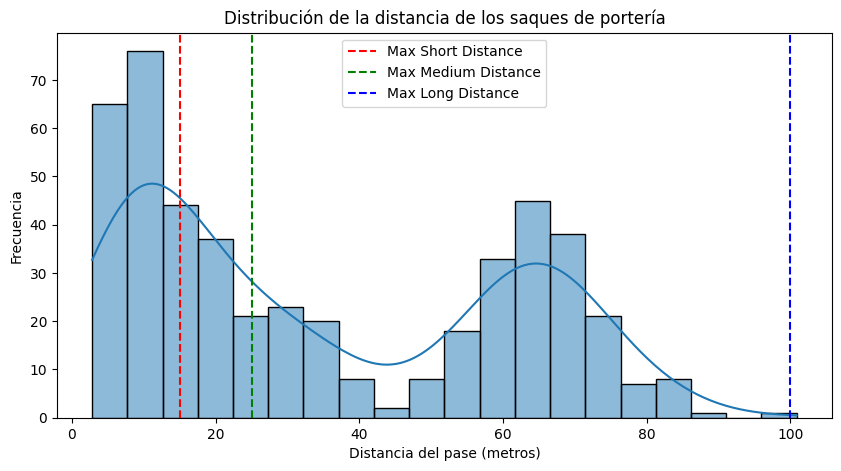

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(goalkicks_df['pass_length'], bins=20, kde=True)
plt.axvline(max_distance_short, color='r', linestyle='--', label='Max Short Distance')
plt.axvline(max_distance_medium, color='g', linestyle='--', label='Max Medium Distance')
plt.axvline(max_distance_long, color='b', linestyle='--', label='Max Long Distance')
plt.legend()
plt.title("Distribución de la distancia de los saques de portería")
plt.xlabel("Distancia del pase (metros)")
plt.ylabel("Frecuencia")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from mplsoccer import Pitch

def goalkick_map(team):
    # Filtrar los saques de portería del equipo seleccionado
    team_goalkicks = goalkicks_df[goalkicks_df["team"] == team]

    # Separar los saques completados y fallidos según el score
    completed_kicks = team_goalkicks[team_goalkicks["score"] == 1]  # Éxito total
    medium_kicks = team_goalkicks[(team_goalkicks["score"] > 0) & (team_goalkicks["score"] < 1)]  # Éxito parcial
    failed_kicks = team_goalkicks[team_goalkicks["score"] == 0]  # Fallido

    # Crear el campo de juego
    pitch = Pitch(pitch_type='statsbomb', pitch_color='white', line_color='black')
    fig, ax = pitch.draw(figsize=(8, 5.5))
    fig.set_facecolor('white')

    # Función para validar y transformar coordenadas
    def extract_coords(df):
        df = df.dropna(subset=['start_location', 'pass_end_location'])  # Eliminar NaN
        xstart = df['start_location'].apply(lambda x: x[0] if isinstance(x, (list, tuple)) else None)
        ystart = df['start_location'].apply(lambda x: x[1] if isinstance(x, (list, tuple)) else None)
        xend = df['pass_end_location'].apply(lambda x: x[0] if isinstance(x, (list, tuple)) else None)
        yend = df['pass_end_location'].apply(lambda x: x[1] if isinstance(x, (list, tuple)) else None)

        return pd.to_numeric(xstart, errors='coerce'), pd.to_numeric(ystart, errors='coerce'), \
               pd.to_numeric(xend, errors='coerce'), pd.to_numeric(yend, errors='coerce')

    # Dibujar los saques por tipo
    for kicks_df, color, label in [(completed_kicks, 'red', "Completado"),
                                   (medium_kicks, 'orange', "Parcialmente exitoso"),
                                   (failed_kicks, 'grey', "Fallido")]:
        xstart, ystart, xend, yend = extract_coords(kicks_df)

        # Filtrar valores válidos
        valid_indices = xstart.notna() & ystart.notna() & xend.notna() & yend.notna()
        xstart, ystart, xend, yend = xstart[valid_indices], ystart[valid_indices], xend[valid_indices], yend[valid_indices]

        # Dibujar los saques
        pitch.arrows(
            xstart, ystart, xend, yend,
            width=2, headwidth=5, headlength=3, color=color, ax=ax, label=label
        )

    # Agregar leyenda
    ax.legend(facecolor='white', handlelength=5, edgecolor='None', fontsize=7, loc='best')

    # Agregar título
    ax.set_title(f"Mapa de saques de portería - {team}", fontsize=12, color='black')

    # Mostrar el gráfico
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import Pitch

def goalkick_heatmap(team):
    # Filtrar los saques de portería del equipo seleccionado
    team_goalkicks = goalkicks_df[goalkicks_df["team"] == team]

    # Extraer las coordenadas de los puntos finales de los saques
    team_goalkicks = team_goalkicks.dropna(subset=['pass_end_location'])  # Eliminar filas con valores NaN
    x_end = team_goalkicks['pass_end_location'].apply(lambda x: x[0] if isinstance(x, (list, tuple)) else None)
    y_end = team_goalkicks['pass_end_location'].apply(lambda x: x[1] if isinstance(x, (list, tuple)) else None)

    # Convertir a valores numéricos y eliminar valores inválidos
    x_end = pd.to_numeric(x_end, errors='coerce')
    y_end = pd.to_numeric(y_end, errors='coerce')
    valid_indices = x_end.notna() & y_end.notna()
    x_end, y_end = x_end[valid_indices], y_end[valid_indices]

    # Crear el campo de juego
    pitch = Pitch(pitch_type='statsbomb', pitch_color='black', line_color='white')
    fig, ax = pitch.draw(figsize=(8, 5.5))
    fig.set_facecolor('black')

    # Crear el heatmap
    sns.kdeplot(
        x=x_end, y=y_end, fill=True, cmap="magma", alpha=0.7, levels=50, ax=ax
    )

    # Agregar título
    ax.set_title(f"Mapa de calor de saques de portería - {team}", fontsize=12, color='black')

    # Mostrar el gráfico
    plt.show()

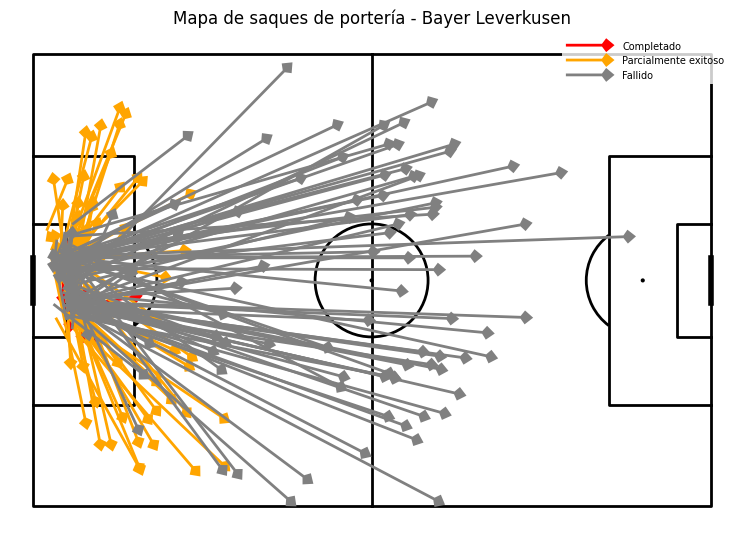

In [ ]:
goalkick_map("Bayer Leverkusen")

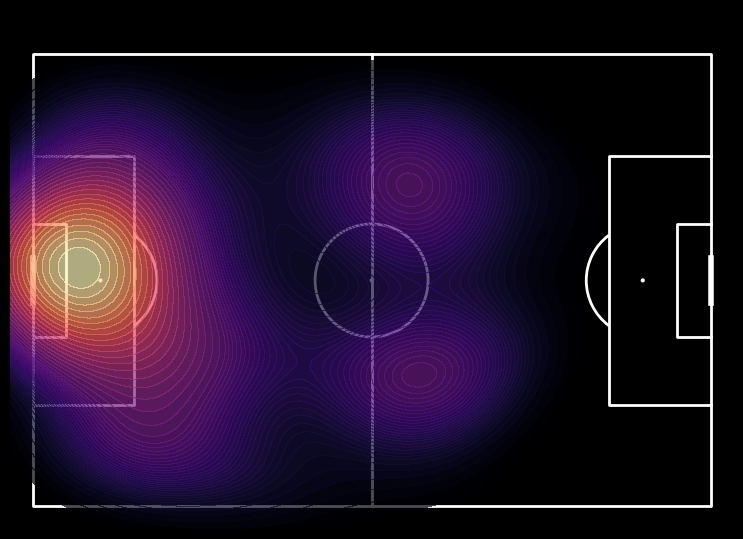

In [ ]:
goalkick_heatmap("Bayer Leverkusen")

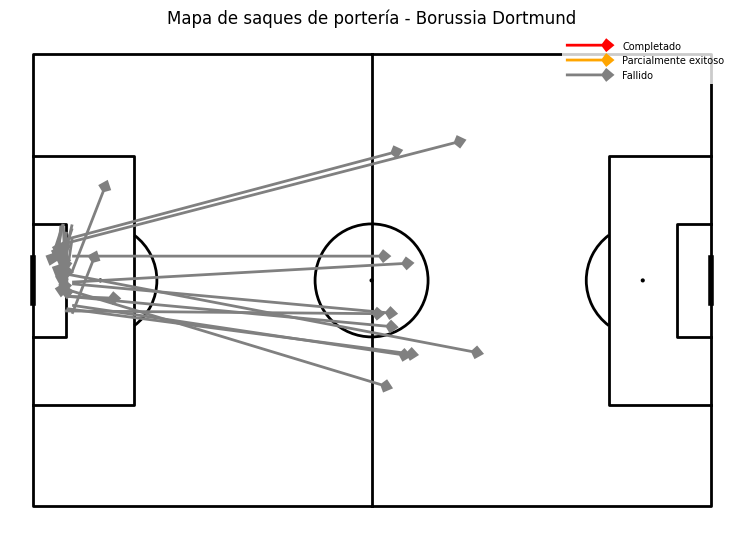

In [ ]:
goalkick_map("Borussia Dortmund")

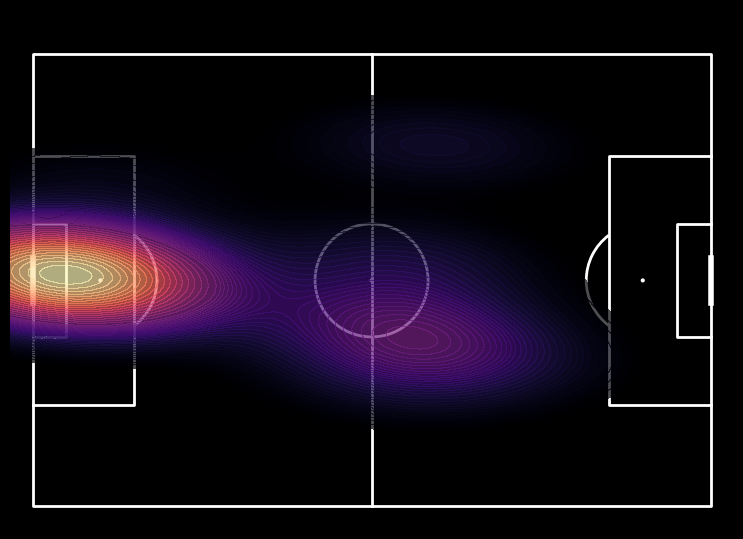

In [ ]:
goalkick_heatmap("Borussia Dortmund")

/tmp/ipython-input-1929209725.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=team_counts.head(10), x="Número de Saques", y="Equipo", palette="Blues_r")


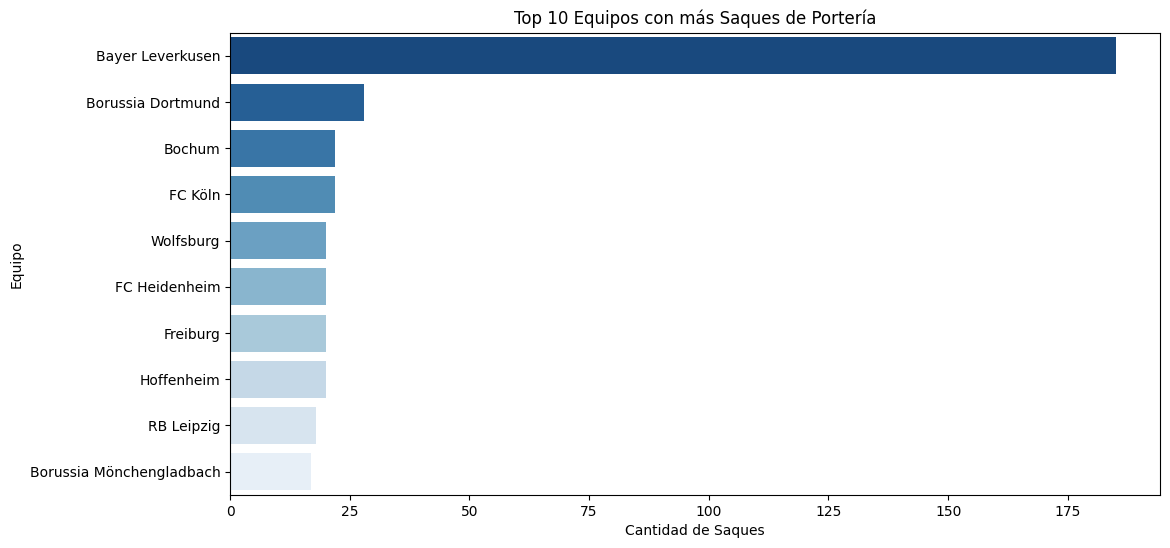

,Equipo,Número de Saques
0,Bayer Leverkusen,185
1,Borussia Dortmund,28
2,Bochum,22
3,FC Köln,22
4,Wolfsburg,20
5,FC Heidenheim,20
6,Freiburg,20
7,Hoffenheim,20
8,RB Leipzig,18
9,Borussia Mönchengladbach,17


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def team_goalkick_ranking():
    # Contar la frecuencia de saques de portería por equipo
    team_counts = goalkicks_df["team"].value_counts().reset_index()
    team_counts.columns = ["Equipo", "Número de Saques"]

    # Graficar la cantidad de saques por equipo (top 10 para mejor visualización)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=team_counts.head(10), x="Número de Saques", y="Equipo", palette="Blues_r")
    plt.title("Top 10 Equipos con más Saques de Portería")
    plt.xlabel("Cantidad de Saques")
    plt.ylabel("Equipo")
    plt.show()

    return team_counts

# Llamar a la función
team_goalkick_ranking()

In [ ]:
missing_values = goalkicks_df.isnull().sum().reset_index()
missing_values.columns = ["Columna", "Valores Nulos"]
missing_values[missing_values["Valores Nulos"] > 0]

,Columna,Valores Nulos
25,pass_recipient,18
26,pass_recipient_id,18
36,teammate_1,320
37,teammate_2,320
38,teammate_3,321
39,teammate_4,323
40,teammate_5,333
41,teammate_6,347
42,teammate_7,391
43,teammate_8,410


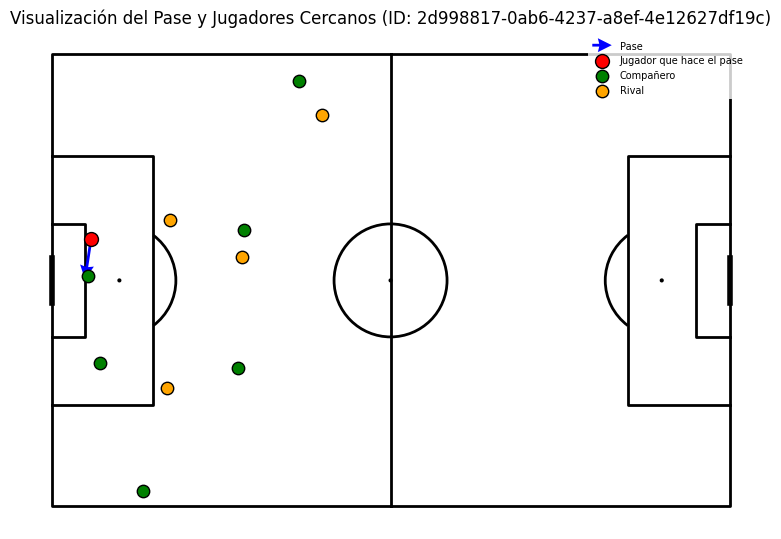

In [ ]:
selected_id = "2d998817-0ab6-4237-a8ef-4e12627df19c"  # Cambia este valor según necesites

# Buscar la fila correspondiente al goalkick_id seleccionado
if selected_id in goalkicks_df['id'].values:
    fila = goalkicks_df[goalkicks_df['id'] == selected_id].index[0]
else:
    print(f"⚠️ El ID {selected_id} no se encontró en el dataset.")
    fila = None

# Si se encontró la fila, generar la visualización
if fila is not None:
    # Crear el campo de juego
    pitch = Pitch(pitch_type='statsbomb', pitch_color='white', line_color='black')
    fig, ax = pitch.draw(figsize=(8, 5.5))
    fig.set_facecolor('white')

    # Extraer las coordenadas del pase
    start_x, start_y = goalkicks_df.loc[fila, 'start_location']
    end_x, end_y = goalkicks_df.loc[fila, 'pass_end_location']

    # Dibujar el pase con una flecha
    pitch.arrows(
        start_x, start_y, end_x, end_y,
        width=2, headwidth=5, headlength=5, color='blue', ax=ax, label="Pase"
    )

    # Dibujar el jugador que hace el pase (actor)
    pitch.scatter(start_x, start_y, color='red', edgecolors='black', s=100, label="Jugador que hace el pase", ax=ax)

    # Dibujar los compañeros de equipo en verde
    for col in [c for c in goalkicks_df.columns if 'teammate_' in c]:
        if isinstance(goalkicks_df.loc[fila, col], list):
            x, y = goalkicks_df.loc[fila, col]
            pitch.scatter(x, y, color='green', edgecolors='black', s=80, ax=ax, label="Compañero" if col == 'teammate_1' else "")

    # Dibujar los rivales en naranja
    for col in [c for c in goalkicks_df.columns if 'rival_' in c]:
        if isinstance(goalkicks_df.loc[fila, col], list):
            x, y = goalkicks_df.loc[fila, col]
            pitch.scatter(x, y, color='orange', edgecolors='black', s=80, ax=ax, label="Rival" if col == 'rival_1' else "")

    # Agregar leyenda
    ax.legend(facecolor='white', edgecolor='None', fontsize=7, loc='best')

    # Título del gráfico
    ax.set_title(f"Visualización del Pase y Jugadores Cercanos (ID: {selected_id})", fontsize=12, color='black')

    # Mostrar el gráfico
    plt.show()

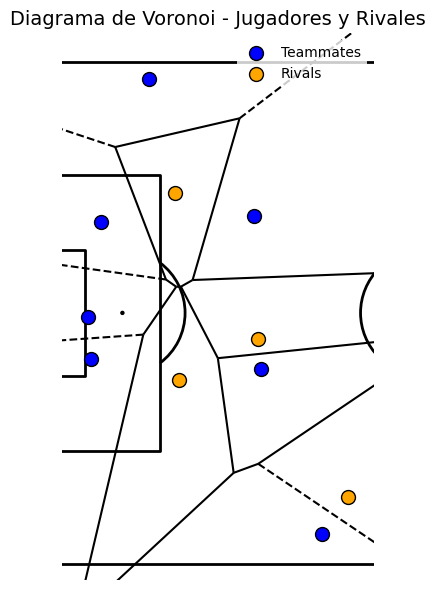

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from mplsoccer import Pitch

# Coordenadas de los jugadores (Bayer Leverkusen)
players_positions = np.array([
    [7.0, 32.6],
    [6.533521704481586, 39.271823066479534],
    [8.655589717566812, 54.5369347789621],
    [16.234167252826893, 77.34080242877286],
    [32.91950764646003, 55.43422422283731],
    [34.1388967928752, 31.09957134217246],
    [43.85843629457135, 4.646213298500264]
])

# Posiciones de los rivales
rival_positions = np.array([
    [20.455852293302115, 59.05564211675761],
    [21.034509478045806, 29.294133031057157],
    [33.6559610045755, 35.8137675270031],
    [47.934464719447504, 10.684773205179887]
])

# Definir el campo de fútbol
pitch = Pitch(pitch_type='statsbomb', pitch_color='white', line_color='black')
fig, ax = pitch.draw(figsize=(10, 6))
fig.set_facecolor('white')

# Crear diagrama de Voronoi para los jugadores
all_positions = np.vstack([players_positions, rival_positions])
vor = Voronoi(all_positions)
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=1.5, point_size=0)

# Dibujar jugadores de tu equipo (Bayer Leverkusen) en azul
ax.scatter(players_positions[:, 0], players_positions[:, 1], color='blue', edgecolors='black', s=100, label="Teammates")

# Dibujar los jugadores rivales en naranja
ax.scatter(rival_positions[:, 0], rival_positions[:, 1], color='orange', edgecolors='black', s=100, label="Rivals")

# Agregar leyenda y título
ax.legend(facecolor='white', edgecolor='None', fontsize=10, loc='upper right')
ax.set_title("Diagrama de Voronoi - Jugadores y Rivales", fontsize=14, color='black')

# Mostrar la figura
plt.show()

In [ ]:
import pandas as pd

# Contar cuántos eventos corresponden a cada posición
position_counts = goalkicks_df["position"].value_counts()

# Calcular el porcentaje de cada posición
position_percentage = (position_counts / position_counts.sum()) * 100

# Crear DataFrame con los resultados
position_distribution = pd.DataFrame({
    "Posición": position_counts.index,
    "Cantidad de Saques": position_counts.values,
    "Porcentaje (%)": position_percentage.values
})

# Mostrar tabla
position_distribution

,Posición,Cantidad de Saques,Porcentaje (%)
0,01. Goalkeeper,358,75.210084
1,03. Left Center Back,94,19.747899
2,04. Center Back,17,3.571429
3,05. Right Center Back,7,1.470588


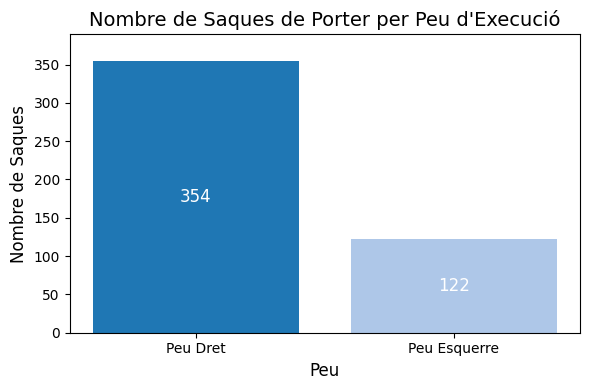

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Comptatge per peu
counts = (
    goalkicks_df['pass_body_part']
    .value_counts()
    .reindex(['Right Foot', 'Left Foot'], fill_value=0)
)

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(
    ['Peu Dret', 'Peu Esquerre'],
    counts.values,
    color=['#1f77b4', '#aec7e8']
)

# Ajustar l’eix Y per deixar-hi un 10% d’espai addicional
ymax = counts.values.max() * 1.1
ax.set_ylim(0, ymax)

# Posicionar les etiquetes al centre de la barra (dins)
ax.bar_label(
    bars,
    labels=counts.values,
    label_type='center',
    color='white',
    fontsize=12
)

ax.set_title("Nombre de Saques de Porter per Peu d'Execució", fontsize=14)
ax.set_xlabel("Peu", fontsize=12)
ax.set_ylabel("Nombre de Saques", fontsize=12)

plt.tight_layout()
plt.show()

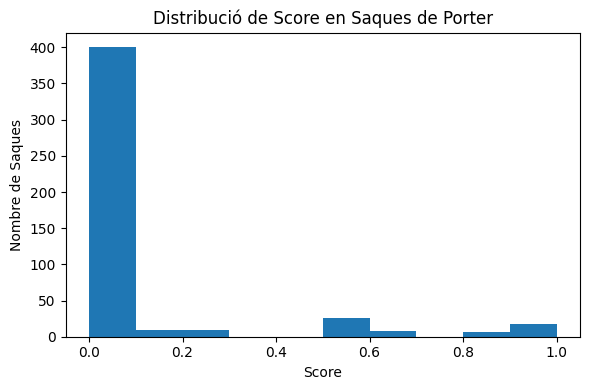

/tmp/ipython-input-1634417230.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=periods)


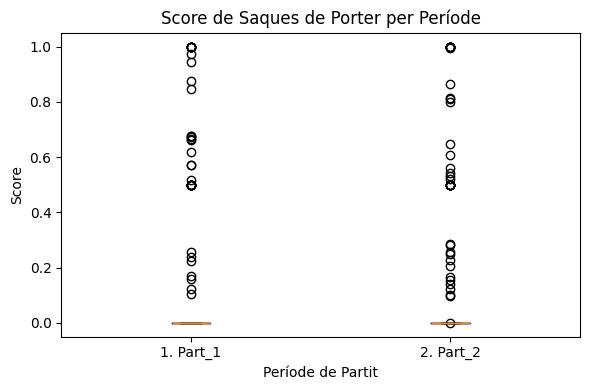

In [ ]:
import matplotlib.pyplot as plt

# 1) Histograma de la distribució de 'score'
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(goalkicks_df['score'].dropna(), bins=10)
ax.set_title("Distribució de Score en Saques de Porter")
ax.set_xlabel("Score")
ax.set_ylabel("Nombre de Saques")
plt.tight_layout()
plt.show()

# 2) Boxplot de 'score' per període (1a i 2a part)
periods = sorted(goalkicks_df['period'].dropna().unique())
data = [goalkicks_df.loc[goalkicks_df['period'] == p, 'score'].dropna() for p in periods]

fig, ax = plt.subplots(figsize=(6, 4))
ax.boxplot(data, labels=periods)
ax.set_title("Score de Saques de Porter per Període")
ax.set_xlabel("Període de Partit")
ax.set_ylabel("Score")
plt.tight_layout()
plt.show()